# Add bench to valid

In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer
import umap

from grnndata import GRNAnnData, read_h5ad, from_anndata
from grnndata import utils 
from bengrn import BenGRN, get_sroy_gt


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

from bengrn.base import get_GT_db

from scprint.utils import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

from bengrn.base import train_classifier
from scib_metrics.benchmark import Benchmarker

from scprint.tasks import Embedder
from bengrn import compute_genie3, compute_scenic

from joblib import dump, load
from bengrn.base import compute_pr
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-04-19 18:02:00,645:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-04-19 18:02:00,755:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-04-19 18:02:00,851:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-04-19 18:02:00,939:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-04-19 18:02:01,034:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-04-19 18:02:01,211:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/arboreto/core.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask D

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [3]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad') 

KeyboardInterrupt: 

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


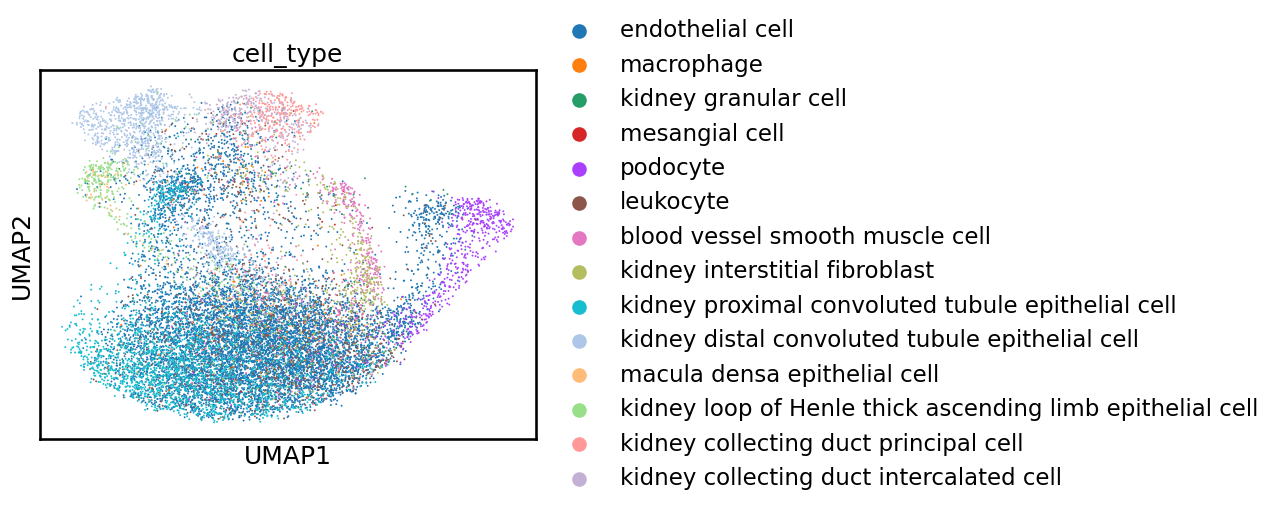

In [ ]:
sc.pl.umap(adata, color="cell_type")

In [3]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/

In [4]:
preprocessor = Preprocessor(use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [7]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())
adata.obs

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 0 genes.
startin QC
Seeing 4678 outliers (28.56% of total dataset):
done


tech celltype  size_factors  \
c27c4bb9-1e85-4333-afda-59e75afc78ab   celseq    gamma      0.028492   
0bb620f8-dc00-4519-bee7-2299470fd98e   celseq    gamma      0.079348   
8ac0a632-6791-4f2a-bc65-2a1f52412998   celseq    gamma      0.037932   
22e85e79-c066-4263-bbc6-6d2da253956d   celseq    gamma      0.047685   
ea4ab6e1-248d-4d54-abf5-37c33e30bf46   celseq    gamma      0.038683   
...                                       ...      ...           ...   
75c2b90b-5f2a-4306-82a1-978fd12690f9  smarter    gamma      1.000000   
03fbfc1c-e79c-4a05-a691-493d472275e5  smarter    gamma      1.000000   
a88a61b9-b37d-45bb-8fcc-175776815633  smarter    gamma      1.000000   
3836863e-1832-4e38-b73c-fbdc21219e65  smarter    gamma      1.000000   
6ae2d752-3d5d-44af-bc8d-86adc5e50cab  smarter    gamma      1.000000   

                                     organism_ontology_term_id   nnz  \
c27c4bb9-1e85-4333-afda-59e75afc78ab            NCBITaxon:9606  1857   
0bb620f8-dc00-4519-bee7-2299470fd98e            NCBITaxon:9606  1857   
8ac0a632-6791-4f2a-bc65-2a1f52412998            NCBITaxon:9606  1857   
22e85e79-c066-4263-bbc6-6d2da253956d            NCBITaxon:9606  1857   
ea4ab6e1-248d-4d54-abf5-37c33e30bf46            NCBITaxon:9606  1857   
...                                                        ...   ...   
75c2b90b-5f2a-4306-82a1-978fd12690f9            NCBITaxon:9606  1857   
03fbfc1c-e79c-4a05-a691-493d472275e5            NCBITaxon:9606  1857   
a88a61b9-b37d-45bb-8fcc-175776815633            NCBITaxon:9606  1857   
3836863e-1832-4e38-b73c-fbdc21219e65            NCBITaxon:9606  1857   
6ae2d752-3d5d-44af-bc8d-86adc5e50cab            NCBITaxon:9606  1857   

                                      n_genes_by_counts  \
c27c4bb9-1e85-4333-afda-59e75afc78ab               1767   
0bb620f8-dc00-4519-bee7-2299470fd98e               3537   
8ac0a632-6791-4f2a-bc65-2a1f52412998               2145   
22e85e79-c066-4263-bbc6-6d2da253956d               2501   
ea4ab6e1-248d-4d54-abf5-37c33e30bf46               2127   
...                                                 ...   
75c2b90b-5f2a-4306-82a1-978fd12690f9               5517   
03fbfc1c-e79c-4a05-a691-493d472275e5               4923   
a88a61b9-b37d-45bb-8fcc-175776815633               6010   
3836863e-1832-4e38-b73c-fbdc21219e65               3932   
6ae2d752-3d5d-44af-bc8d-86adc5e50cab               3789   

                                      log1p_n_genes_by_counts   total_counts  \
c27c4bb9-1e85-4333-afda-59e75afc78ab                 7.477604    3921.636475   
0bb620f8-dc00-4519-bee7-2299470fd98e                 8.171317   10230.473633   
8ac0a632-6791-4f2a-bc65-2a1f52412998                 7.671361    4730.720703   
22e85e79-c066-4263-bbc6-6d2da253956d                 7.824846    5925.487793   
ea4ab6e1-248d-4d54-abf5-37c33e30bf46                 7.662938    4619.637695   
...                                                       ...            ...   
75c2b90b-5f2a-4306-82a1-978fd12690f9                 8.615771  479020.906250   
03fbfc1c-e79c-4a05-a691-493d472275e5                 8.501876  314639.062500   
a88a61b9-b37d-45bb-8fcc-175776815633                 8.701346  403987.843750   
3836863e-1832-4e38-b73c-fbdc21219e65                 8.277158  393747.062500   
6ae2d752-3d5d-44af-bc8d-86adc5e50cab                 8.240121  443699.187500   

                                      log1p_total_counts  \
c27c4bb9-1e85-4333-afda-59e75afc78ab            8.274519   
0bb620f8-dc00-4519-bee7-2299470fd98e            9.233224   
8ac0a632-6791-4f2a-bc65-2a1f52412998            8.462044   
22e85e79-c066-4263-bbc6-6d2da253956d            8.687187   
ea4ab6e1-248d-4d54-abf5-37c33e30bf46            8.438288   
...                                                  ...   
75c2b90b-5f2a-4306-82a1-978fd12690f9           13.079502   
03fbfc1c-e79c-4a05-a691-493d472275e5           12.659184   
a88a61b9-b37d-45bb-8fcc-175776815633           12.909142   
3836863e-1832-4e38-b73c-fbdc21219e65     

In [11]:
embedder = Embedder(model, pred_embedding=['cell_type_ontology_term_id'])#), 'sex_ontology_term_id', "disease_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 15728 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

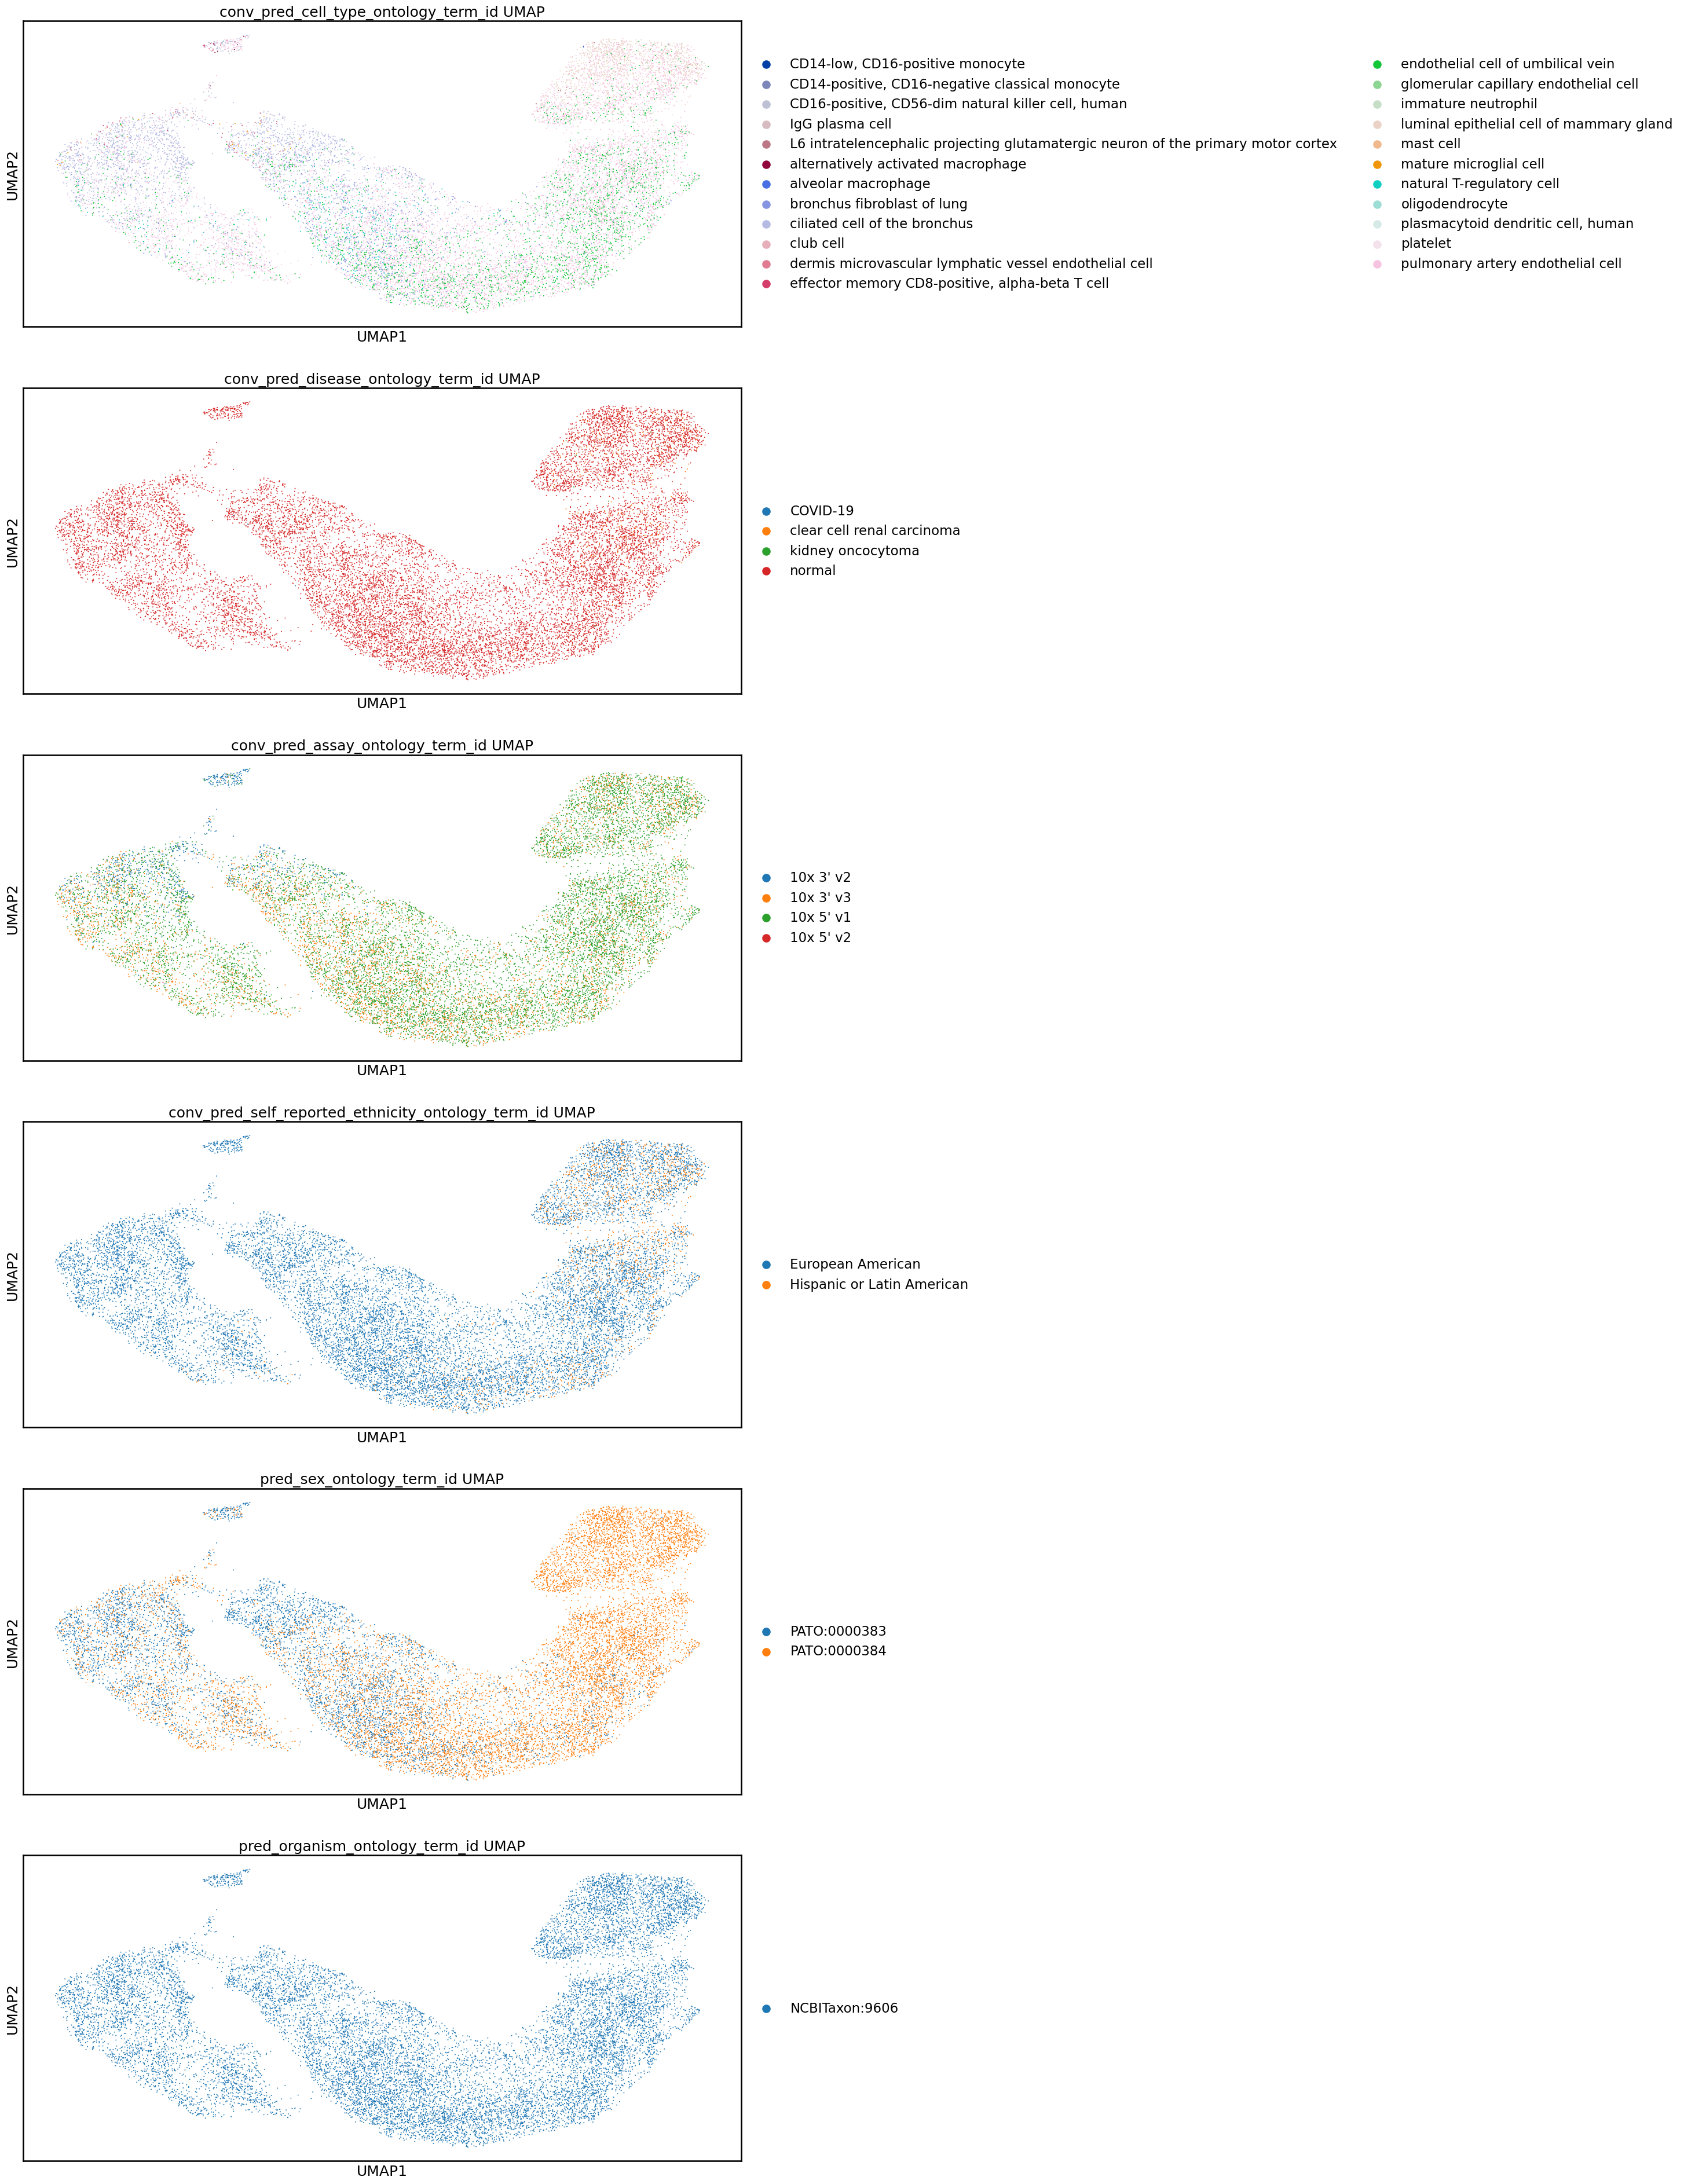

couldn't log to tensorboard
couldn't log to wandb
     cell_type_ontology_term_id
     accuracy: 0.3872711088504578
 
     disease_ontology_term_id
     accuracy: 0.985058494404883
 
     assay_ontology_term_id
     accuracy: 0.0
 
     self_reported_ethnicity_ontology_term_id
     accuracy: 0.9125762970498474
 
     sex_ontology_term_id
     accuracy: 0.6571083418107834
 
     organism_ontology_term_id
     accuracy: 1.0
 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 64 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

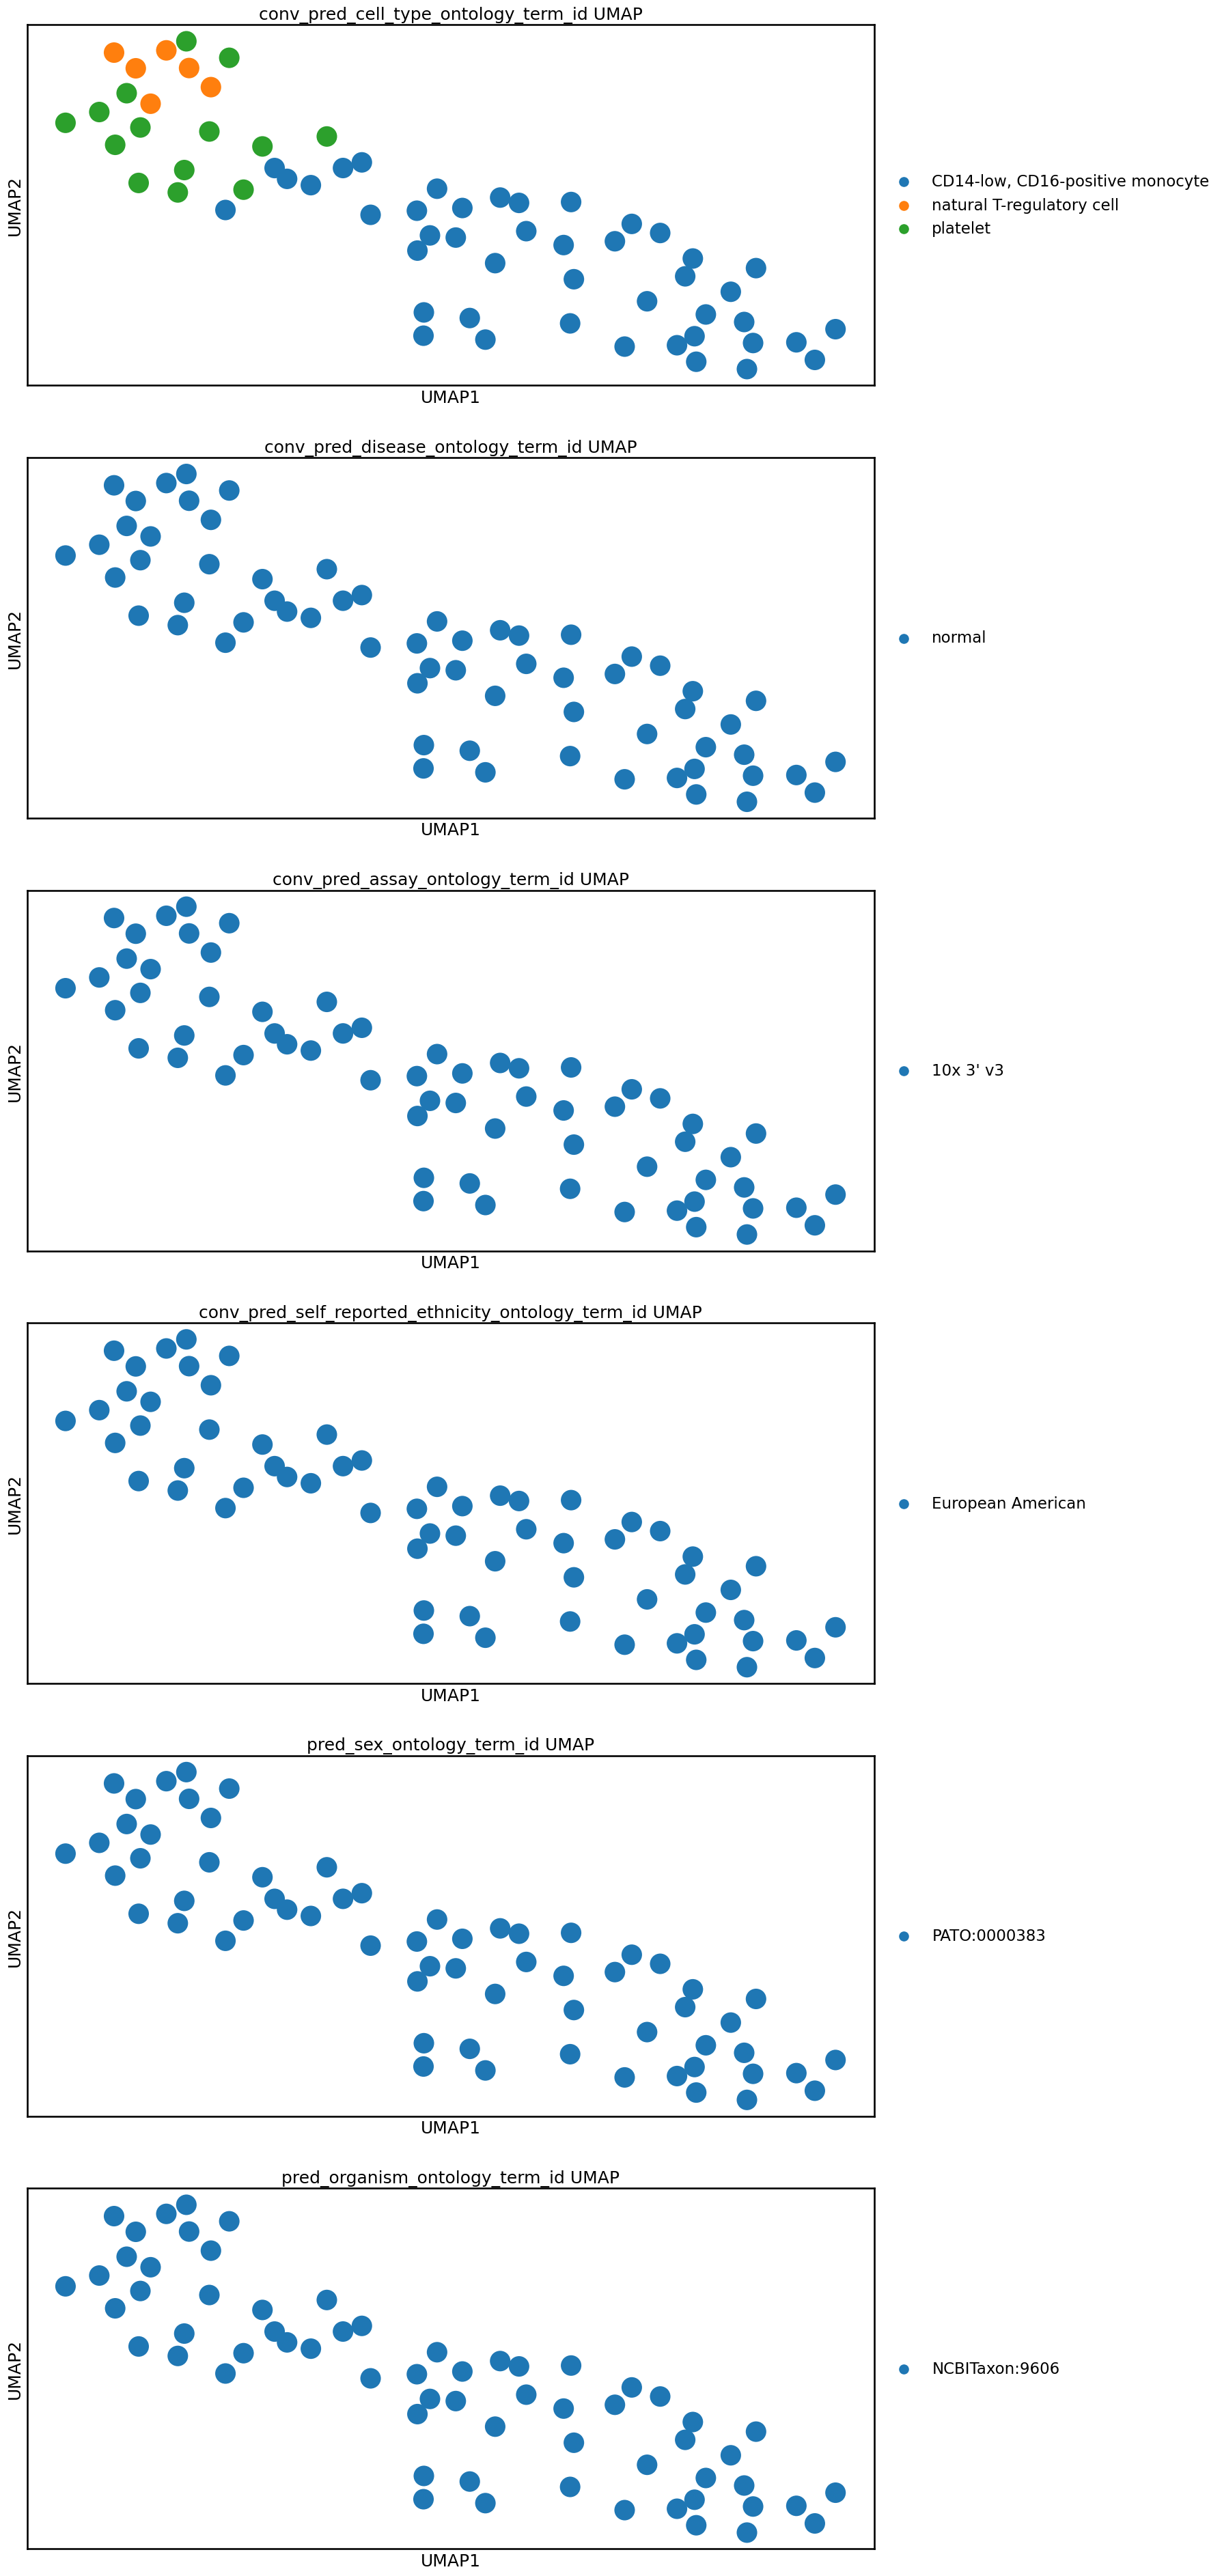

couldn't log to tensorboard
couldn't log to wandb


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [12]:
embed_adata, metrics = embedder(adata.copy())

In [11]:
bm = Benchmarker(
    embed_adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-15 10:56:47,641:INFO - isolated labels: no more than 4 batches per label
2024-04-15 10:56:47,724:INFO - Unable to initialize backend 'cuda': 
2024-04-15 10:56:47,726:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-04-15 10:56:47,731:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-04-15 10:56:47,732:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:50<00:25,  6.26s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [01:04<00:26,  8.97s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-15 10:57:53,558:INFO - isolated labels: no more than 4 batches per label

Metrics:  60%|██████    | 6/10 [04:08<01:41, 25.33s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.v

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [04:24<01:06, 22.27s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Metrics:  70%|███████   | 7/10 [04:24<01:06, 22.27s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████ | 9/10 [04:26<00:11, 11.89s/it, Batch correction: pcr_comparison]██████████| 2/2 [05:31<00:00, 183.62s/it]██████████| 2/2 [05:31<00:00, 165.97s/it]

                                                                                         

In [12]:
df = bm.get_results(min_max_scale=False)

In [13]:
metrics.update(df.T.to_dict()['scprint'])

In [15]:
metrics

{'organism_ontology_term_id_accuracy': 1.0,
 'recons_corr': 0.41429276677234056,
 'mean_regress': 0.16875615336027333,
 'Isolated labels': 0.5709986090660095,
 'KMeans NMI': 0.0807827198713779,
 'KMeans ARI': 0.023430237443821698,
 'Silhouette label': 0.44825203716754913,
 'cLISI': 0.8853379029494065,
 'Silhouette batch': 0.8465379476547241,
 'iLISI': 0.09784001111984253,
 'KBET': 0.07300052524291156,
 'Graph connectivity': 0.3157003784575895,
 'PCR comparison': 0,
 'Batch correction': 0.26661577249501356,
 'Bio conservation': 0.40176030129963297,
 'Total': 0.3477024897777852}

In [4]:
grn_inferer = GRNfer(model, adata,
    how="most var across",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    max_cells=64,
    cell_type_col="cell_type",
    #k=
    #genes=
    #known_grn
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type="leukocyte")

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:300: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 2607 ...
doing regression....


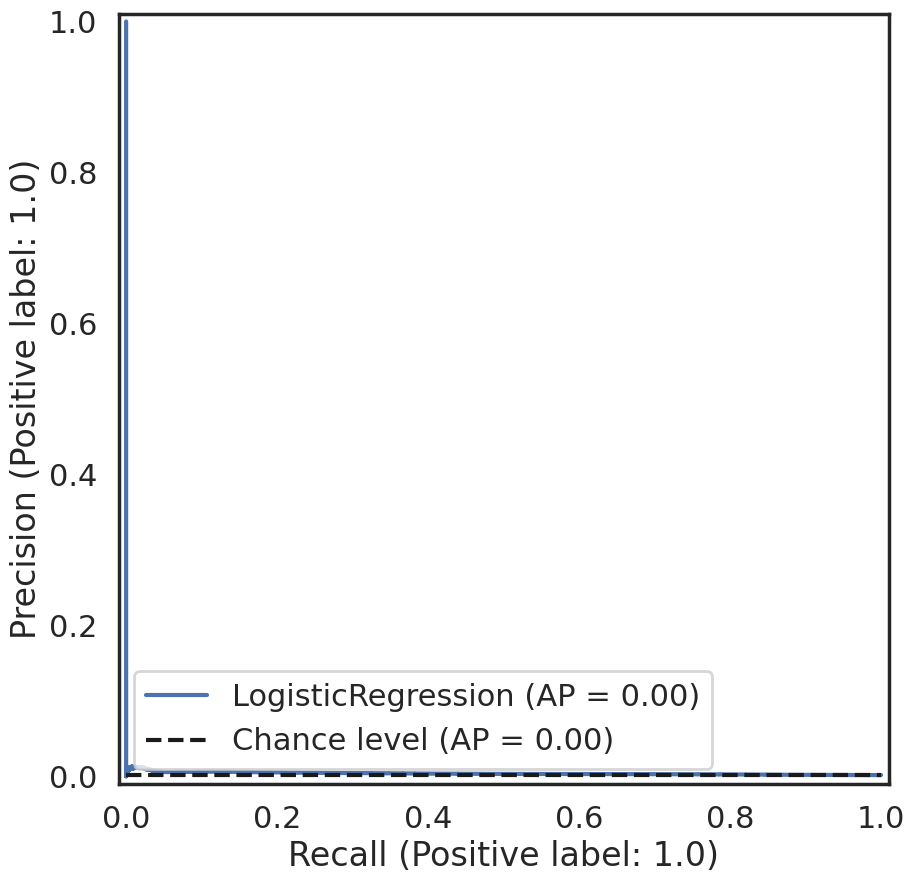

In [38]:
grn, m = train_classifier(grn, C=0.2, class_weight={1:200, 0:1})

In [39]:
m

{'used_heads': 31,
 'precision': 0.011395348837209301,
 'random_precision': 0.0016722434697178,
 'recall': 0.023366714353838816,
 'random_recall': 0.0034290161753870005,
 'predicted_true': 4300.0,
 'number_of_true': 2097.0}

In [40]:
grn.varp['GRN'] = grn.varp['classified']

base enrichment
Top central genes: []


2024-04-16 19:03:12,462 [WARNING] Duplicated values found in preranked stats: 64.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Non-classical monocytes', 'celltype.gmt__Classical Monocytes', 'celltype.gmt__Hematopoietic cells', 'celltype.gmt__Immune cells']


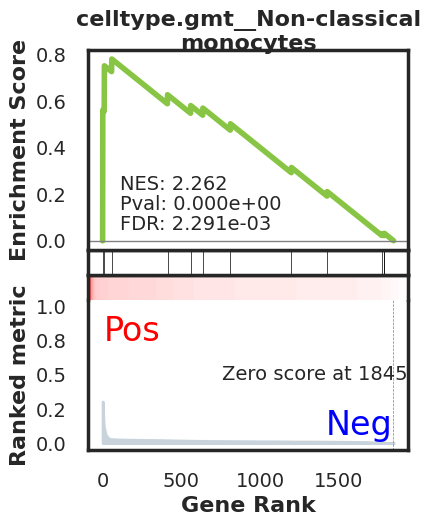

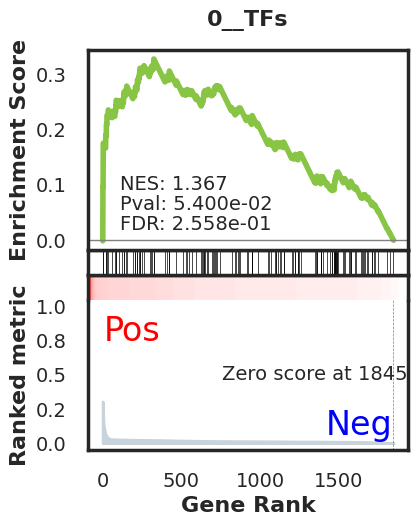

2024-04-16 19:03:14,155 [WARNING] Duplicated values found in preranked stats: 15.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


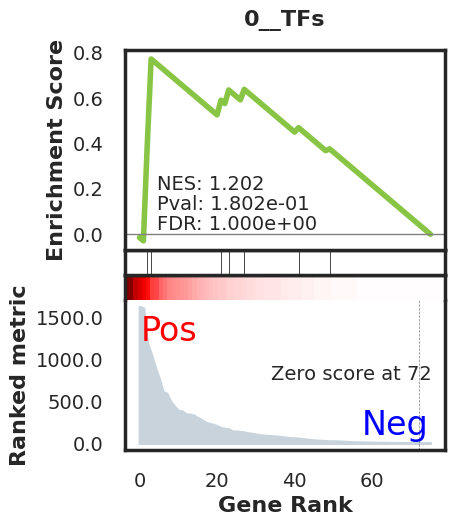

2024-04-16 19:03:14,808 [WARNING] Duplicated values found in preranked stats: 98.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Pulmonary alveolar type II cells', 'celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Erythroid-like and erythroid precursor cells', 'celltype.gmt__Immune cells', 'celltype.gmt__Classical Monocytes', 'celltype.gmt__Intermediate monocytes', 'celltype.gmt__Acinar cells', 'celltype.gmt__Alpha cells', 'celltype.gmt__Hepatocytes', 'celltype.gmt__Neutrophils']


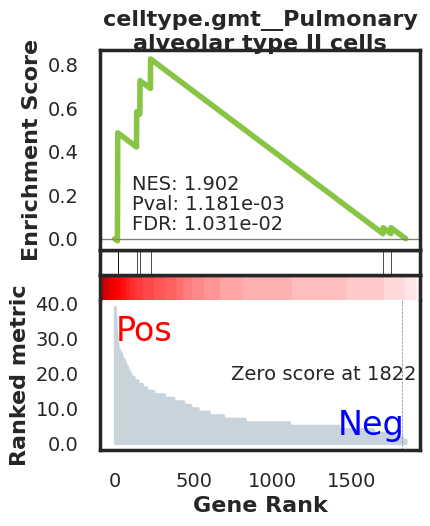

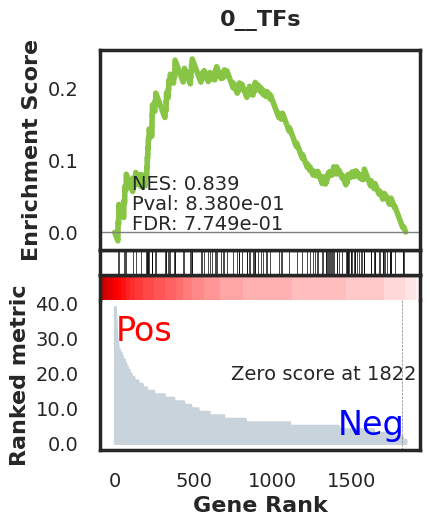

_________________________________________
TF specific enrichment


2024-04-16 19:03:16,613:INFO - Downloading and generating Enrichr library gene sets...
2024-04-16 19:03:16,615:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-16 19:03:16,829:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-16 19:03:16,840 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:16,978 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,138 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,297 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,468 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,623 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,782 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-16 19:03:17,922 [WARNING] Duplicated values found in preranked stats: 99.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1252 genes
intersection pct: 0.6778559826746074
precision:  0.0 
recall:  0.0 
random recall: 0.004622635096233218 
random precision: 0.0034461661401690618


100%|██████████| 49/49 [00:00<00:00, 84.67it/s]


Area Under Precision-Recall Curve (AUPRC):  -0.0
overal increase: (mean, max) (-0.004622635096233219, -0.004622635096233218)


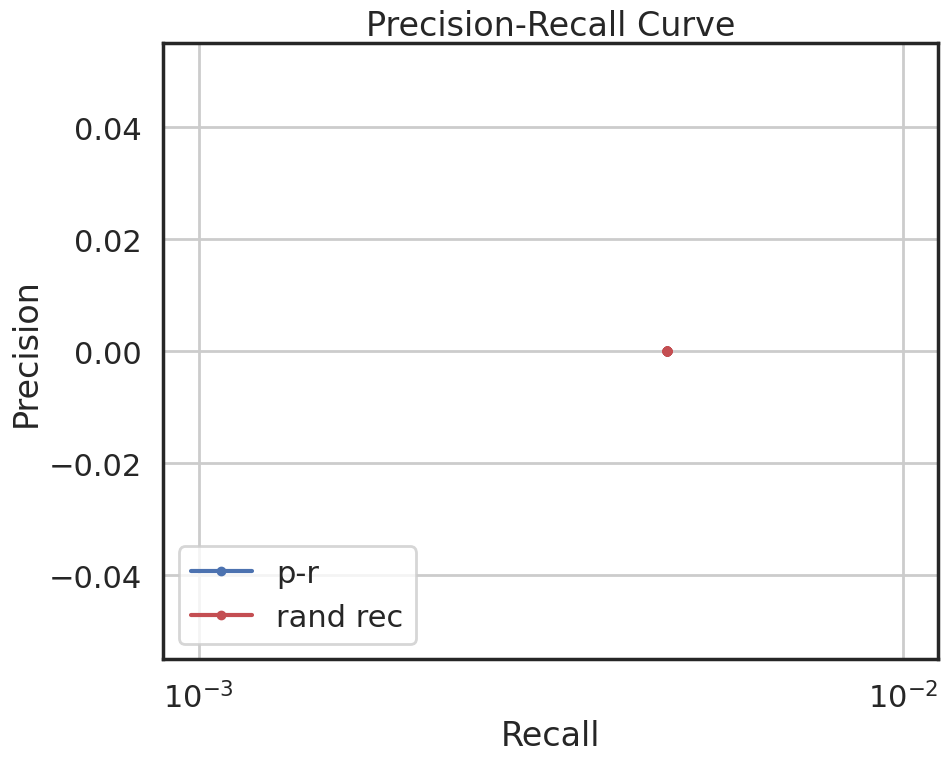

In [41]:
m = BenGRN(grn).scprint_benchmark()

# multi cell type and GENIE3 comparison

In [5]:
adata.var["isTF"]=False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"]=True

In [26]:
grn_inferer = GRNfer(model, adata,
    how="most var across",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    max_cells=128,
    #k=
    #genes=
    #known_grn
)

[autoreload of scprint.tasks failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/__init__.py", line 3, in <module>
    from .denoise import *
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py", line 76
    genelist=genelist
             
SyntaxEr

podocyte
scprint



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 128 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
couldn't log to tensorboard
couldn't log to wandb


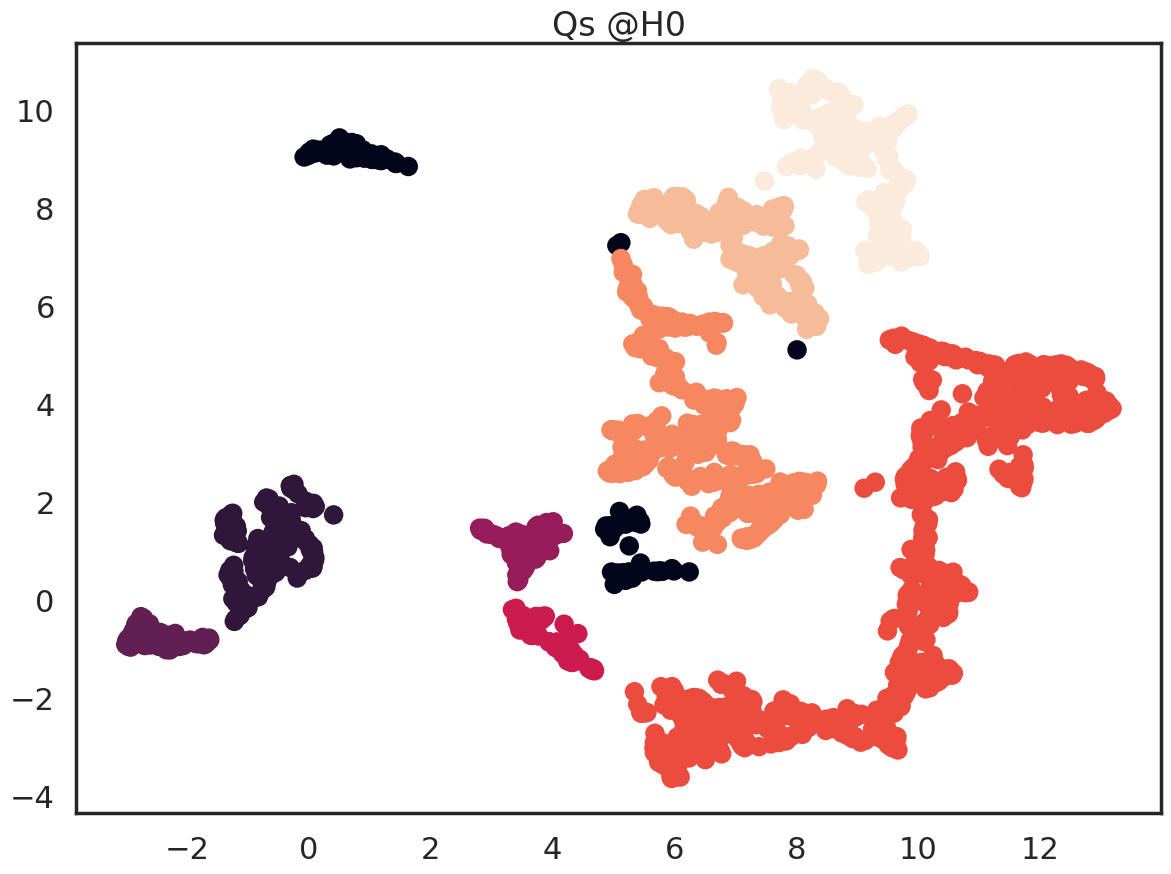

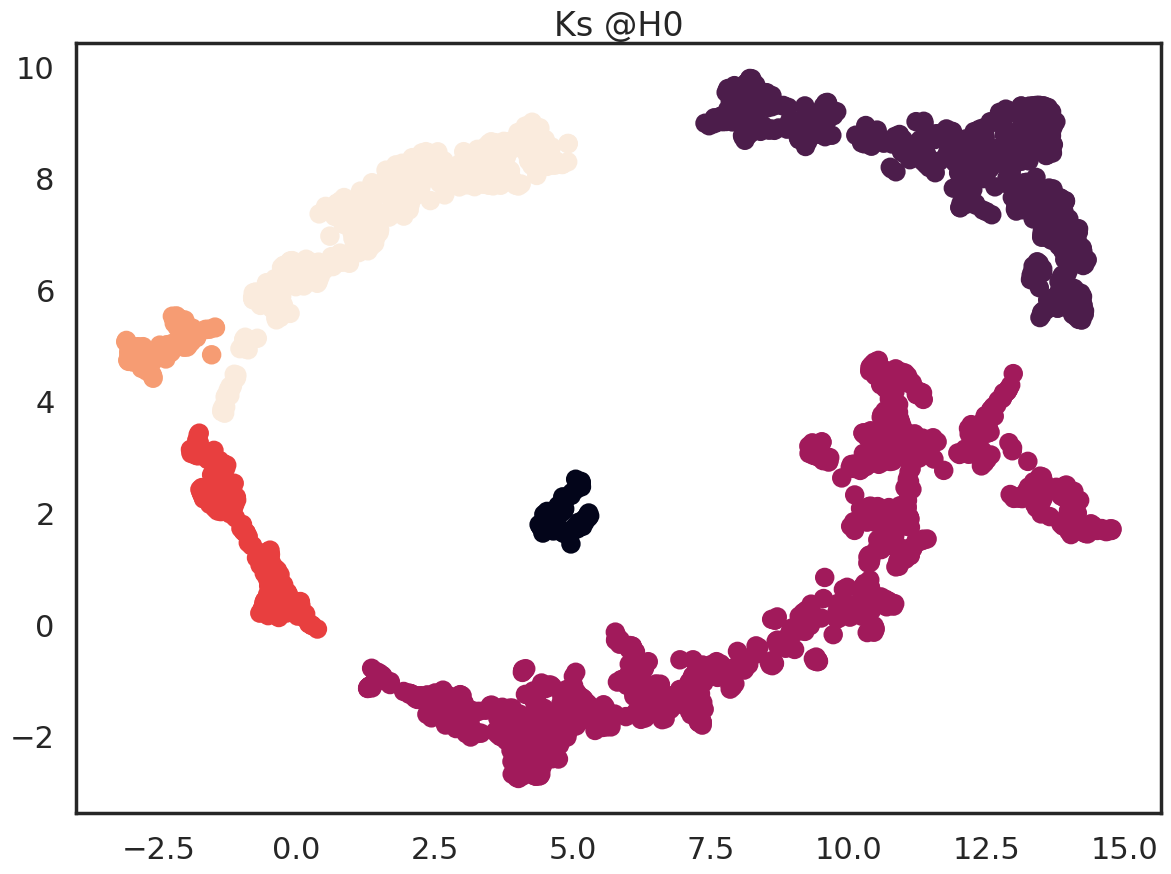

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:303: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 7328 ...
doing regression....


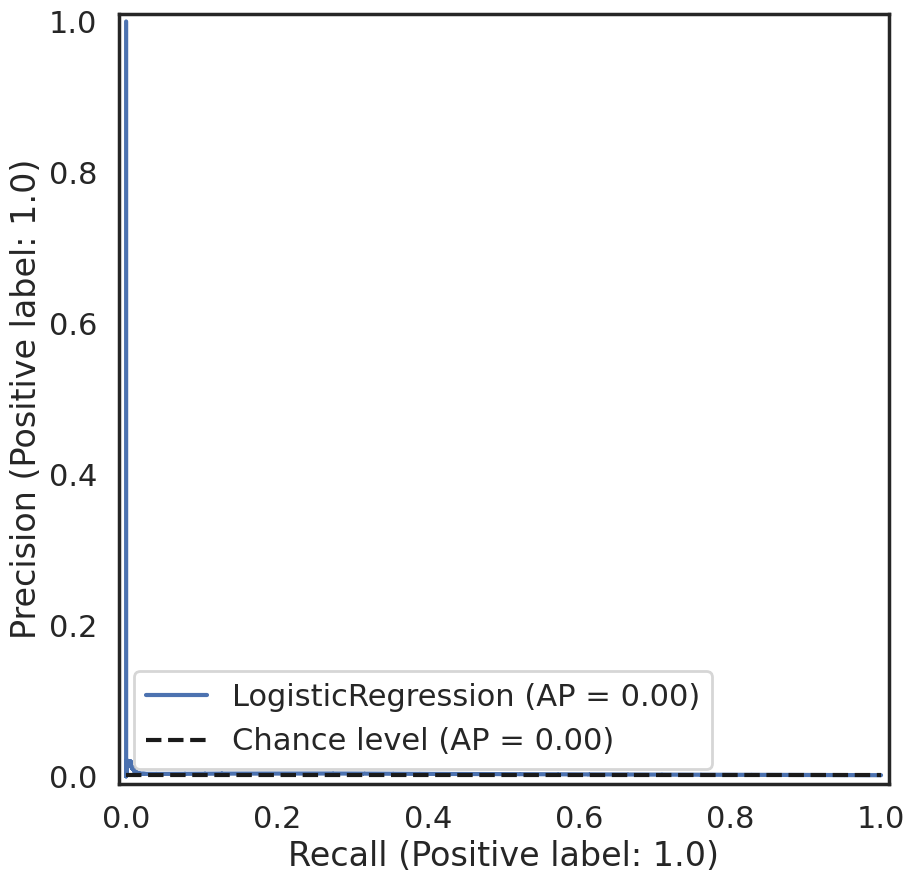

{'used_heads': 46, 'precision': 0.008426202772492526, 'random_precision': 0.0015641563503838588, 'recall': 0.010600102581637887, 'random_recall': 0.001967697457022471, 'predicted_true': 7358.0, 'number_of_true': 5849.0}
base enrichment
Top central genes: []


2024-04-17 12:22:54,153 [WARNING] Duplicated values found in preranked stats: 55.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


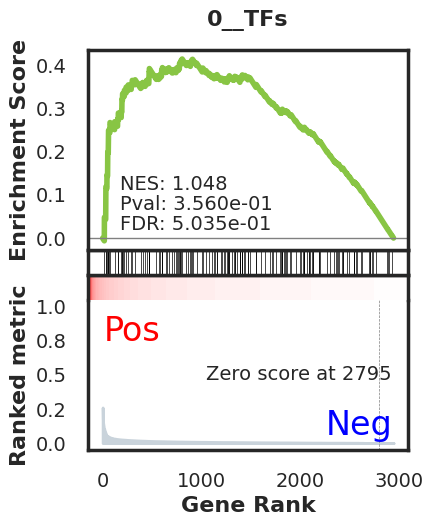

2024-04-17 12:22:56,644 [WARNING] Duplicated values found in preranked stats: 52.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


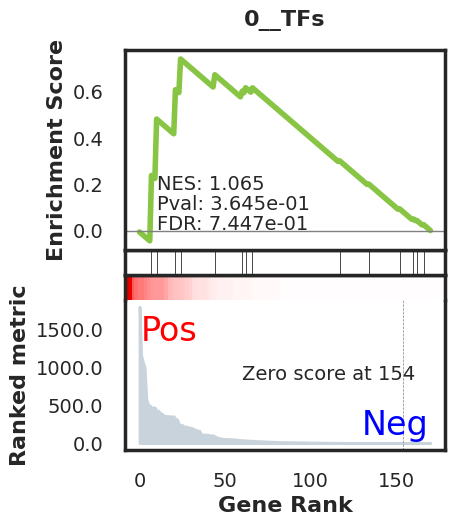

_________________________________________
TF specific enrichment


2024-04-17 12:22:58,014:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:22:58,019:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:22:59,039:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2162 genes
intersection pct: 0.734125636672326
precision:  0.011992619926199263 
recall:  0.01064410480349345 
random recall: 0.0024389795735460717 
random precision: 0.002747976985692745


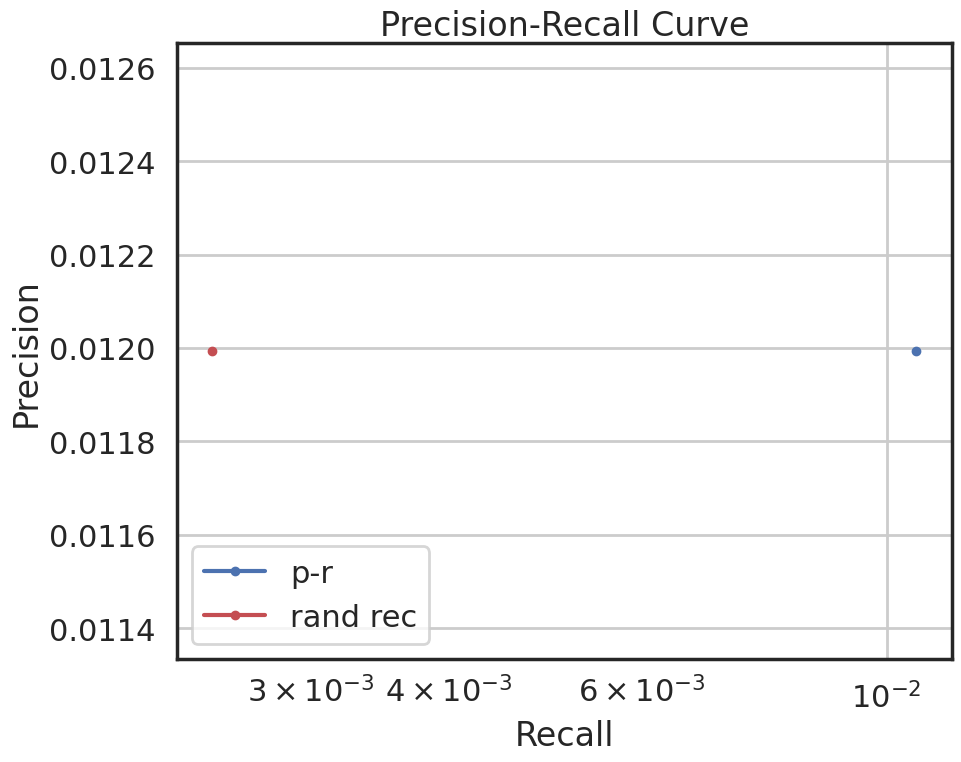

{'significant_enriched_TFtargets': 0.0, 'true_positive': 78, 'true_negative': 2652111, 'false_positive': 7250, 'false_negative': 7250, 'EPR': 3.9355939690844233}
genie3 TF only

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 29.59 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


base enrichment
Top central genes: []


2024-04-17 12:23:38,007 [WARNING] Duplicated values found in preranked stats: 90.53% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['0__TFs', 'celltype.gmt__Embryonic stem cells', 'celltype.gmt__Cap mesenchyme cells (Mesenchymal cells)', 'celltype.gmt__Enteric neurons']


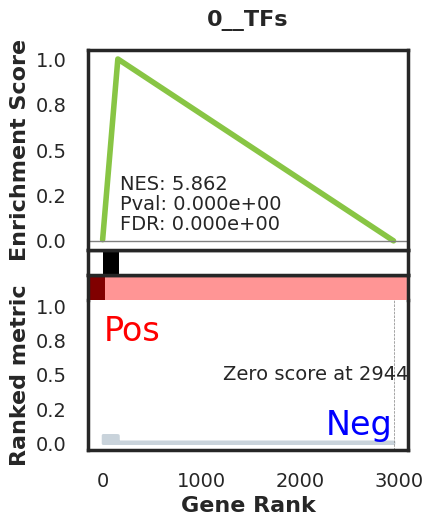

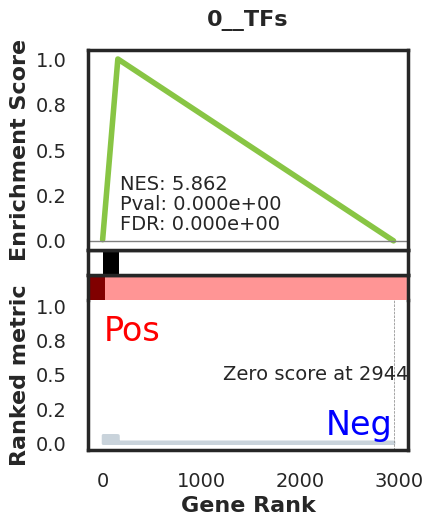

[]
_________________________________________
TF specific enrichment


2024-04-17 12:23:40,930:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:23:40,932:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:23:41,129:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


no sig...


2024-04-17 12:23:41,553 [WARNING] Duplicated values found in preranked stats: 0.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:23:41,932 [WARNING] Duplicated values found in preranked stats: 0.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:23:42,331 [WARNING] Duplicated values found in preranked stats: 0.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
no sig...
found!  0__JUND
0    1.280576
Name: NES, dtype: object




2024-04-17 12:23:43,395 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:23:43,682 [WARNING] Duplicated values found in preranked stats: 0.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:23:44,021 [WARNING] Duplicated values found in preranked stats: 0.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
no sig...
no sig...
found!  0__JUND
0    1.331361
Name: NES, dtype: object


no sig...


2024-04-17 12:23:45,568 [WARNING] Duplicated values found in preranked stats: 0.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found!  0__JUND
0    1.263813
Name: NES, dtype: object


no sig...
found some significant results for  10.714285714285714 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2162 genes
intersection pct: 0.734125636672326
precision:  0.01707837592701275 
recall:  0.43681768558951967 
random recall: 0.07028566135758613 
random precision: 0.002747976985692745



100%|██████████| 49/49 [00:01<00:00, 30.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.007426776459054852
overal increase: (mean, max) (0.020588114947626836, 0.36653202423193354)


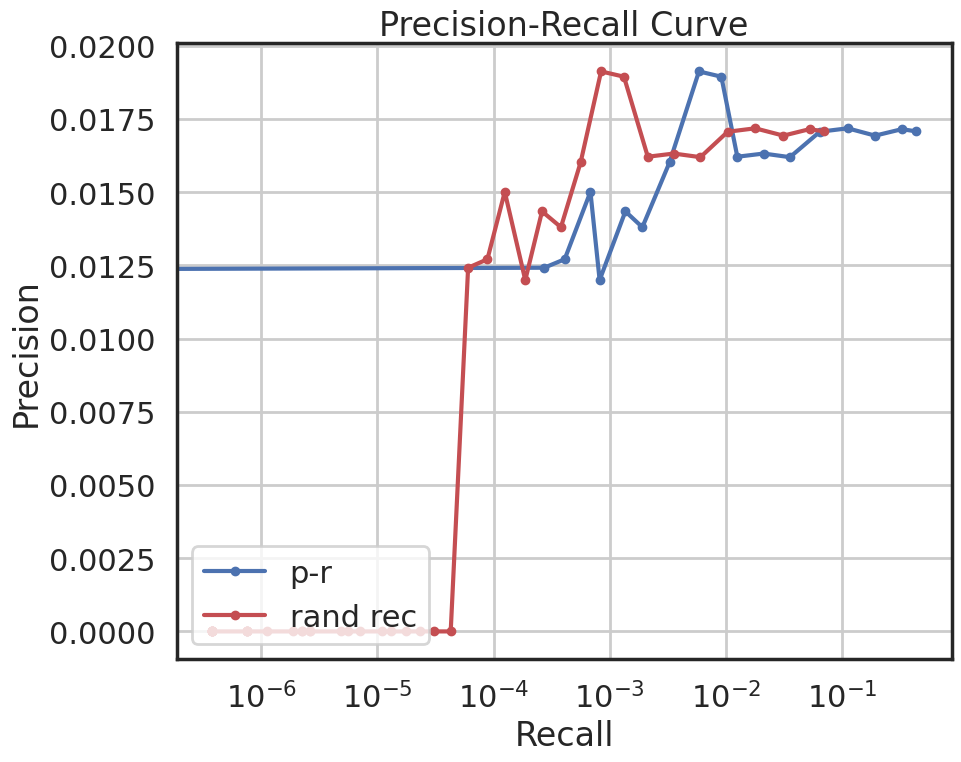

{'enriched_terms_Central': ['0__TFs', 'celltype.gmt__Embryonic stem cells', 'celltype.gmt__Cap mesenchyme cells (Mesenchymal cells)', 'celltype.gmt__Enteric neurons'], 'significant_enriched_TFtargets': 10.714285714285714, 'auprc': 0.007426776459054852, 'pr_increase_to_random': (0.020588114947626836, 0.36653202423193354), 'true_positive': 122, 'true_negative': 2652155, 'false_positive': 7206, 'false_negative': 7206, 'EPR': 6.231178854639667}
genie3

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 58.56 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []
['celltype.gmt__Podocytes', 'celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Myofibroblasts', 'celltype.gmt__Pulmonary alveolar type I cells', 'celltype.gmt__Myoepithelial cells']


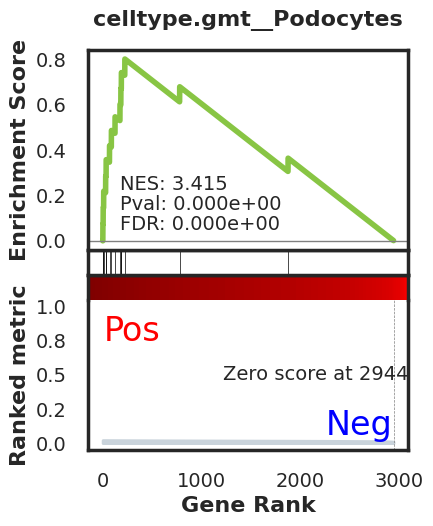

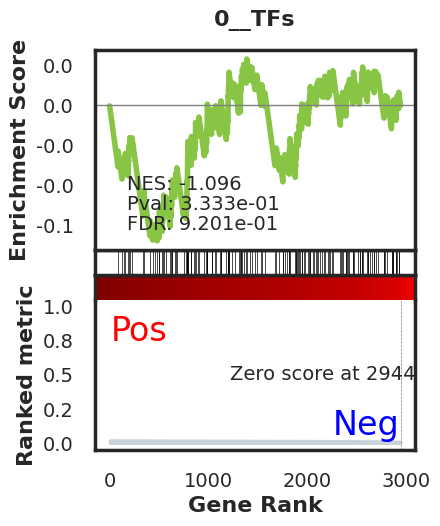

['celltype.gmt__Podocytes', 'celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Pulmonary alveolar type I cells', 'celltype.gmt__Myofibroblasts', 'celltype.gmt__Smooth muscle cells', 'celltype.gmt__Endometrium', 'celltype.gmt__Myocytes']


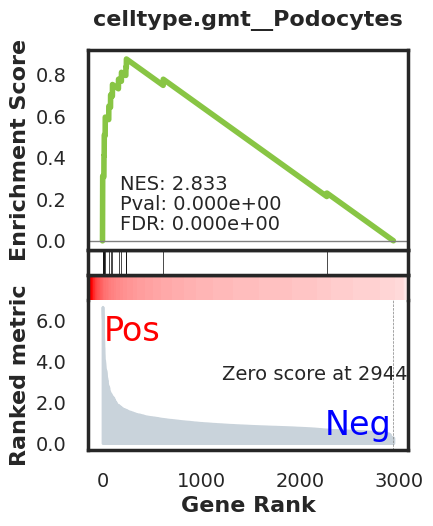

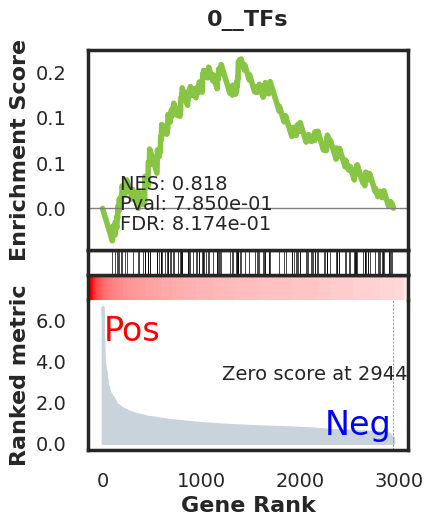

_________________________________________
TF specific enrichment


2024-04-17 12:25:11,039:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:25:11,041:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:25:11,234:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-17 12:25:11,246 [WARNING] Duplicated values found in preranked stats: 42.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:11,443 [WARNING] Duplicated values found in preranked stats: 35.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:11,657 [WARNING] Duplicated values found in preranked stats: 23.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:11,878 [WARNING] Duplicated values found in preranked stats: 47.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:12,113 [WARNING] Duplicated values found in preranked stats: 47.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:12,373 [WARNING] Duplicated values found in preranked stats: 47.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:12,623 [WARNING] Duplicated values found in preranked stats: 34.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:12,856 [WARNING] Duplicated values found in preranked stats: 20.68% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:13,086 [WARNING] Duplicated values found in preranked stats: 35.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:13,303 [WARNING] Duplicated values found in preranked stats: 41.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:13,547 [WARNING] Duplicated values found in preranked stats: 47.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:13,796 [WARNING] Duplicated values found in preranked stats: 29.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:14,043 [WARNING] Duplicated values found in preranked stats: 42.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__SUZ12
0    1.362013
Name: NES, dtype: object




2024-04-17 12:25:14,282 [WARNING] Duplicated values found in preranked stats: 24.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:14,545 [WARNING] Duplicated values found in preranked stats: 24.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:14,778 [WARNING] Duplicated values found in preranked stats: 44.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:15,019 [WARNING] Duplicated values found in preranked stats: 27.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:15,260 [WARNING] Duplicated values found in preranked stats: 35.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:15,505 [WARNING] Duplicated values found in preranked stats: 43.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:15,737 [WARNING] Duplicated values found in preranked stats: 35.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:15,980 [WARNING] Duplicated values found in preranked stats: 27.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:16,211 [WARNING] Duplicated values found in preranked stats: 35.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:16,437 [WARNING] Duplicated values found in preranked stats: 42.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:16,649 [WARNING] Duplicated values found in preranked stats: 43.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:16,868 [WARNING] Duplicated values found in preranked stats: 35.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:17,093 [WARNING] Duplicated values found in preranked stats: 32.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:25:17,343 [WARNING] Duplicated values found in preranked stats: 20.68% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2162 genes
intersection pct: 0.734125636672326
precision:  0.0028334559997778117 
recall:  0.6960971615720524 
random recall: 0.6750974710586799 
random precision: 0.002747976985692745



100%|██████████| 49/49 [00:01<00:00, 45.36it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0018206663331806006
overal increase: (mean, max) (1.1803619758220711e-05, 0.02099969051337247)


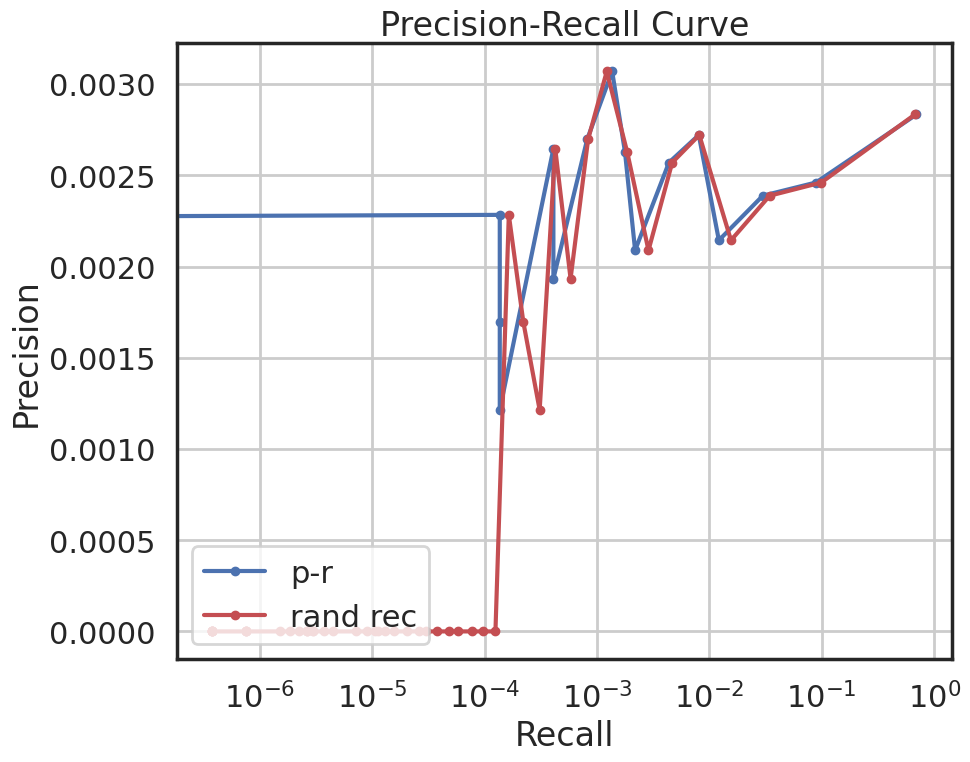

{'enriched_terms_Central': ['celltype.gmt__Podocytes', 'celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Myofibroblasts', 'celltype.gmt__Pulmonary alveolar type I cells', 'celltype.gmt__Myoepithelial cells'], 'enriched_terms_Targets': ['celltype.gmt__Podocytes', 'celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Pulmonary alveolar type I cells', 'celltype.gmt__Myofibroblasts', 'celltype.gmt__Smooth muscle cells', 'celltype.gmt__Endometrium', 'celltype.gmt__Myocytes'], 'significant_enriched_TFtargets': 3.5714285714285716, 'auprc': 0.0018206663331806006, 'pr_increase_to_random': (1.1803619758220711e-05, 0.02099969051337247), 'true_positive': 14, 'true_negative': 2652047, 'false_positive': 7314, 'false_negative': 7314, 'EPR': 0.6940637143983666}
______________________________
macrophage
scprint



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 88 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
couldn't log to tensorboard
couldn't log to wandb


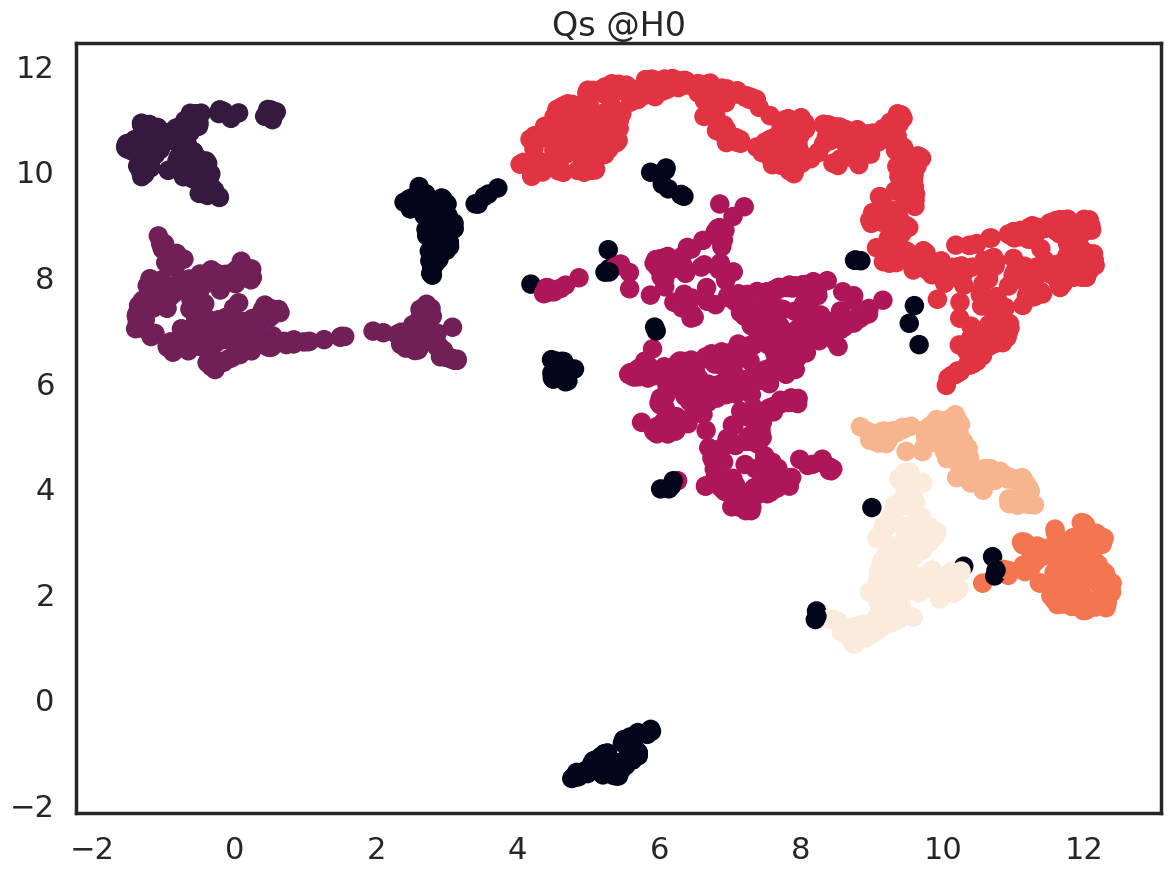

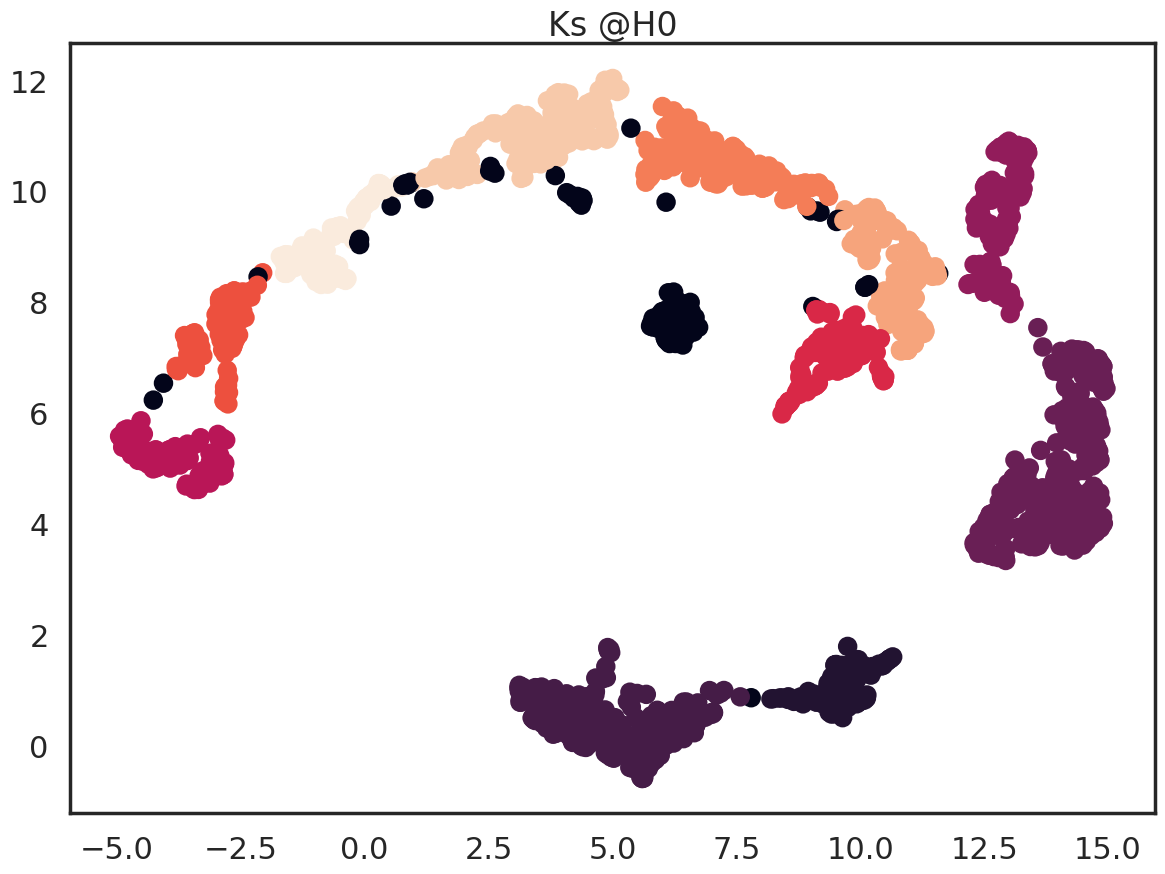

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:303: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 6497 ...
doing regression....


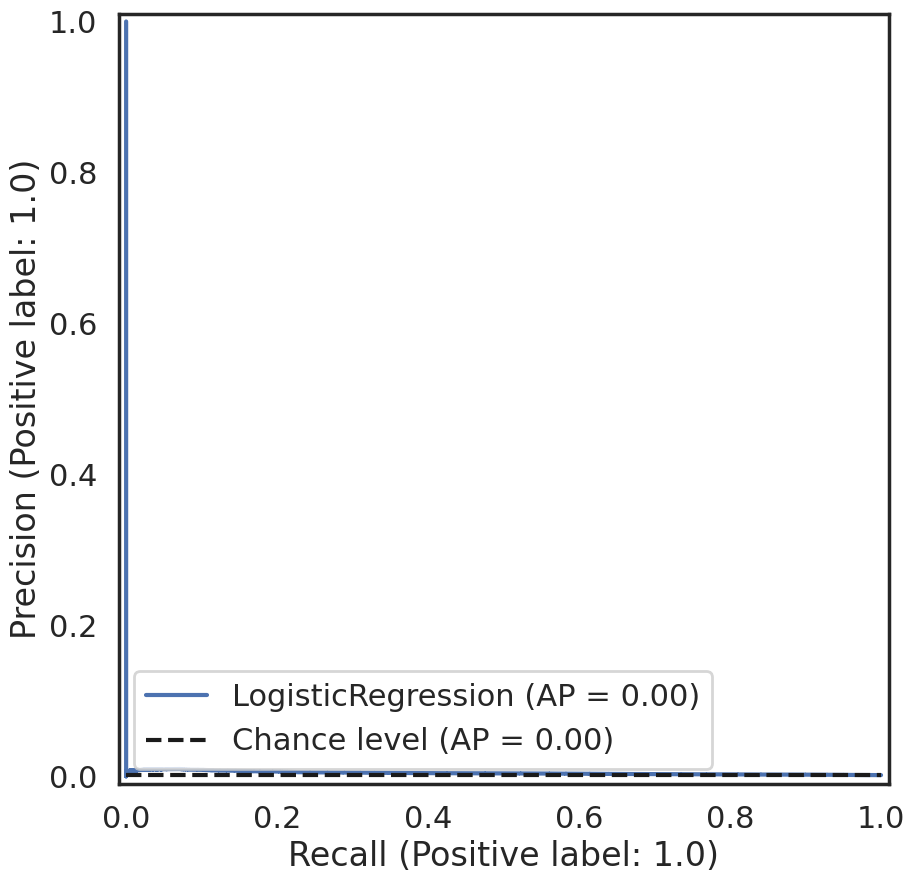

{'used_heads': 57, 'precision': 0.009577612331175876, 'random_precision': 0.0016587854841674363, 'recall': 0.049506865209824016, 'random_recall': 0.008574294567068538, 'predicted_true': 26729.0, 'number_of_true': 5171.0}
base enrichment
Top central genes: []


2024-04-17 12:27:39,182 [WARNING] Duplicated values found in preranked stats: 20.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Immune system cells', 'celltype.gmt__Memory B cells', 'celltype.gmt__Naive B cells', 'celltype.gmt__Plasma B cells', 'celltype.gmt__Cholangiocytes', 'celltype.gmt__Immune cells', 'celltype.gmt__Kupffer cells', 'celltype.gmt__Pre-B cells', 'celltype.gmt__Acinar cells']


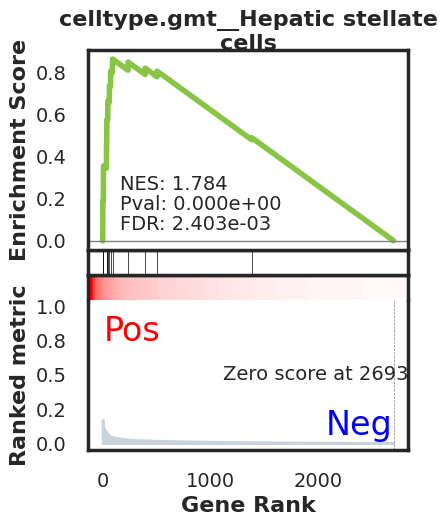

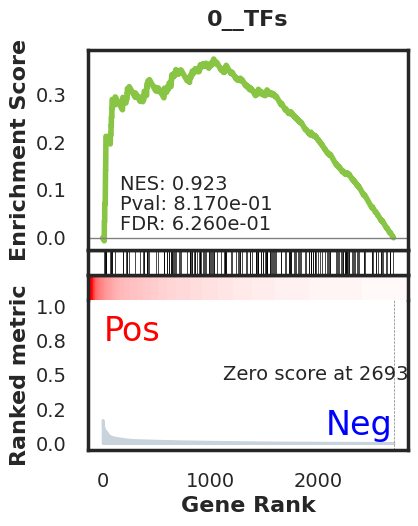

2024-04-17 12:27:41,068 [WARNING] Duplicated values found in preranked stats: 51.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


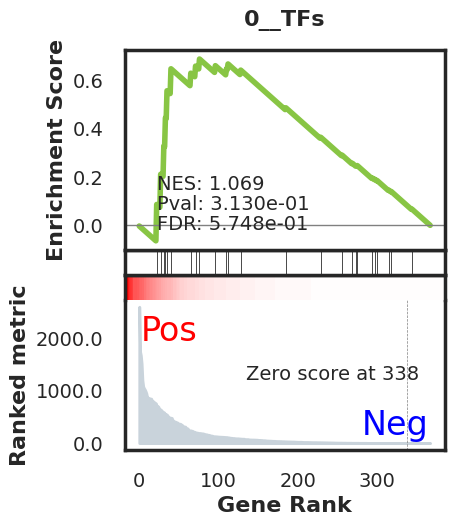

_________________________________________
TF specific enrichment


2024-04-17 12:27:42,165:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:27:42,167:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:27:42,393:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-17 12:27:42,403 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:27:42,597 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:27:42,827 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:27:43,050 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:27:43,264 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:27:43,495 [WARNING] Duplicated values found in preranked stats: 99.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1974 genes
intersection pct: 0.732739420935412
precision:  0.01363673704099236 
recall:  0.051100507926735414 
random recall: 0.011251288796173101 
random precision: 0.003002531147159149


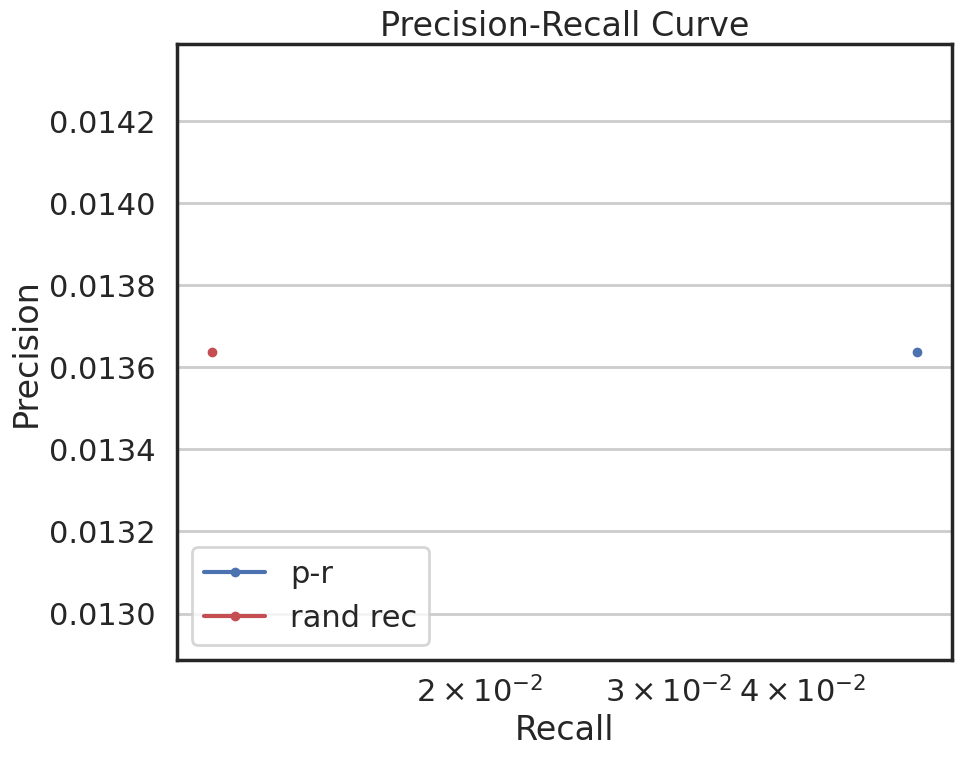

{'enriched_terms_Central': ['celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Immune system cells', 'celltype.gmt__Memory B cells', 'celltype.gmt__Naive B cells', 'celltype.gmt__Plasma B cells', 'celltype.gmt__Cholangiocytes', 'celltype.gmt__Immune cells', 'celltype.gmt__Kupffer cells', 'celltype.gmt__Pre-B cells', 'celltype.gmt__Acinar cells', 'celltype.gmt__Smooth muscle cells', 'celltype.gmt__Alveolar macrophages', 'celltype.gmt__Non-classical monocytes', 'celltype.gmt__Myofibroblasts', 'celltype.gmt__Ductal cells', 'celltype.gmt__Keratinocytes', 'celltype.gmt__Myoepithelial cells', 'celltype.gmt__Astrocytes', 'celltype.gmt__Pulmonary alveolar type I cells', 'celltype.gmt__Hepatocytes', 'celltype.gmt__Microglial cells', 'celltype.gmt__Goblet cells', 'celltype.gmt__Paneth cells', 'celltype.gmt__Langerhans cells', 'celltype.gmt__Sebocytes', 'celltype.gmt__Pancreatic progenitor cells'], 'significant_enriched_TFtargets': 0.0, 'true_positive': 39, 'true_negative': 2150886, 'false_po

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",
[rank: 0] Received SIGTERM: 15


base enrichment
Top central genes: []


2024-04-17 12:28:10,742 [WARNING] Duplicated values found in preranked stats: 0.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['0__TFs', 'celltype.gmt__Tuft cells']


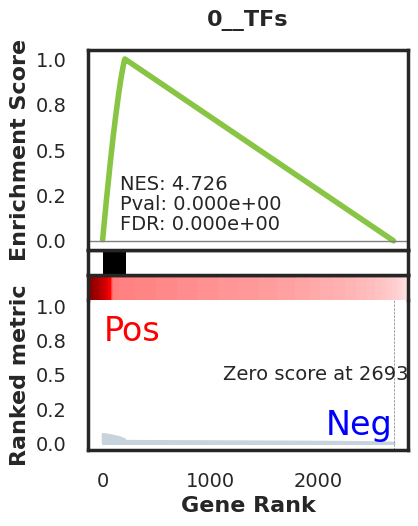

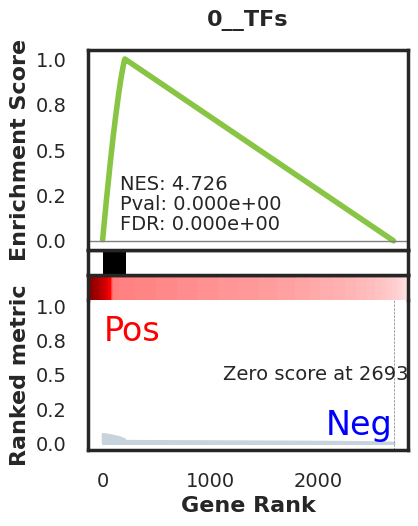

[]
_________________________________________
TF specific enrichment


2024-04-17 12:28:13,372:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:28:13,374:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:28:13,564:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-17 12:28:13,574 [WARNING] Duplicated values found in preranked stats: 10.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:13,808 [WARNING] Duplicated values found in preranked stats: 0.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:14,029 [WARNING] Duplicated values found in preranked stats: 7.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:14,237 [WARNING] Duplicated values found in preranked stats: 20.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:14,470 [WARNING] Duplicated values found in preranked stats: 0.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:14,719 [WARNING] Duplicated values found in preranked stats: 6.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:14,931 [WARNING] Duplicated values found in preranked stats: 31.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:15,163 [WARNING] Duplicated values found in preranked stats: 10.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:15,400 [WARNING] Duplicated values found in preranked stats: 0.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:15,630 [WARNING] Duplicated values found in preranked stats: 7.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:15,850 [WARNING] Duplicated values found in preranked stats: 0.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:16,080 [WARNING] Duplicated values found in preranked stats: 16.30% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:16,307 [WARNING] Duplicated values found in preranked stats: 11.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:16,526 [WARNING] Duplicated values found in preranked stats: 10.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:16,738 [WARNING] Duplicated values found in preranked stats: 22.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:16,955 [WARNING] Duplicated values found in preranked stats: 1.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:17,192 [WARNING] Duplicated values found in preranked stats: 17.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:17,420 [WARNING] Duplicated values found in preranked stats: 31.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:17,636 [WARNING] Duplicated values found in preranked stats: 7.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__JUND
0    1.13661
Name: NES, dtype: object




2024-04-17 12:28:17,854 [WARNING] Duplicated values found in preranked stats: 6.27% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:18,094 [WARNING] Duplicated values found in preranked stats: 17.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:18,306 [WARNING] Duplicated values found in preranked stats: 19.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:18,519 [WARNING] Duplicated values found in preranked stats: 7.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:18,723 [WARNING] Duplicated values found in preranked stats: 17.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found some significant results for  3.7037037037037037 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1974 genes
intersection pct: 0.732739420935412
precision:  0.017180827588779004 
recall:  0.4254271202093274 
random recall: 0.07434788415599852 
random precision: 0.003002531147159149



100%|██████████| 49/49 [00:00<00:00, 60.09it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008517777971675473
overal increase: (mean, max) (0.012446861433141065, 0.35107923605332886)


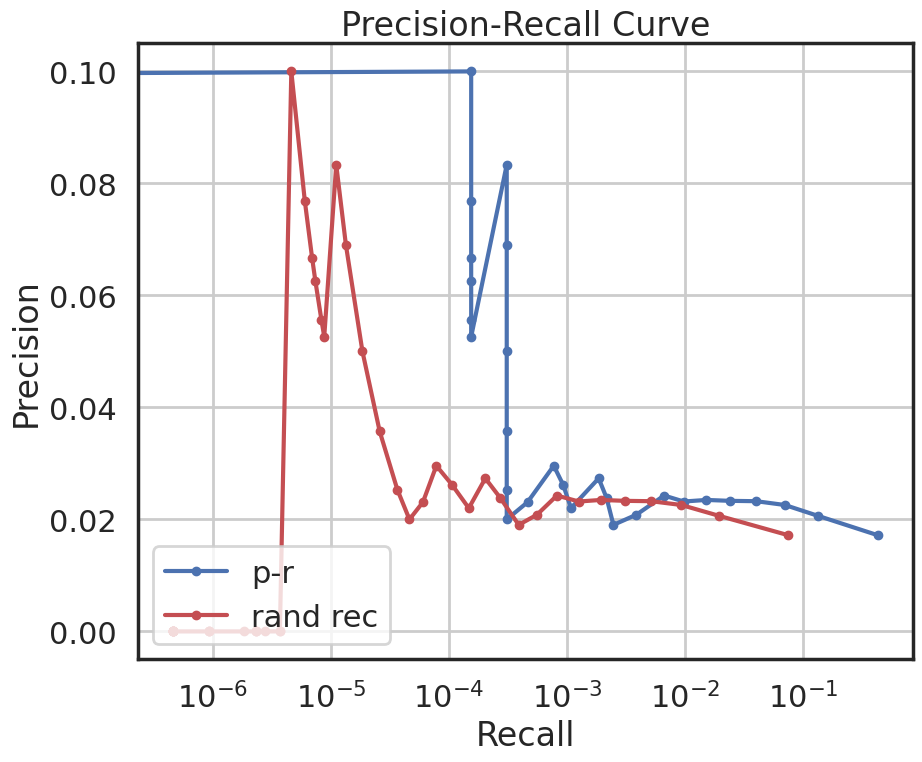

{'enriched_terms_Central': ['0__TFs', 'celltype.gmt__Tuft cells'], 'significant_enriched_TFtargets': 3.7037037037037037, 'auprc': 0.008517777971675473, 'pr_increase_to_random': (0.012446861433141065, 0.35107923605332886), 'true_positive': 150, 'true_negative': 2150997, 'false_positive': 6347, 'false_negative': 6347, 'EPR': 8.009290889683898}
genie3

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 21.05 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",
[rank: 0] Received SIGTERM: 15


base enrichment
Top central genes: []
['celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Myofibroblasts']


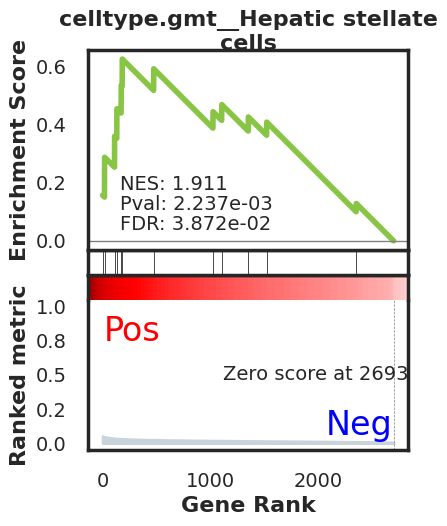

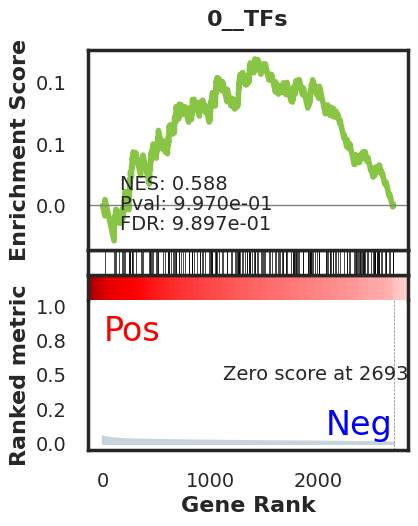

['celltype.gmt__Hepatic stellate cells']


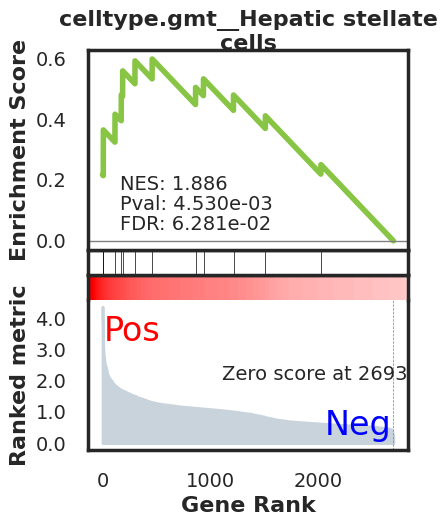

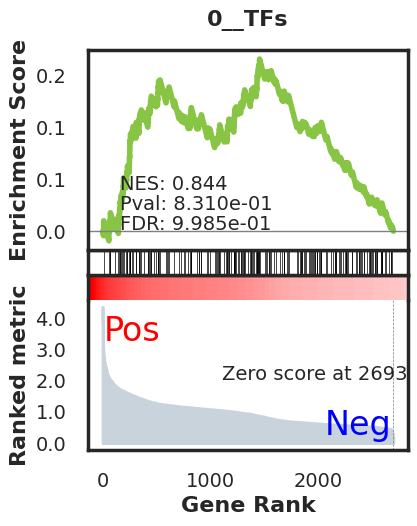

_________________________________________
TF specific enrichment


2024-04-17 12:28:51,748:INFO - Downloading and generating Enrichr library gene sets...
2024-04-17 12:28:51,750:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-17 12:28:51,938:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-17 12:28:51,949 [WARNING] Duplicated values found in preranked stats: 84.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:52,132 [WARNING] Duplicated values found in preranked stats: 60.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:52,340 [WARNING] Duplicated values found in preranked stats: 82.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:52,563 [WARNING] Duplicated values found in preranked stats: 85.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:52,766 [WARNING] Duplicated values found in preranked stats: 60.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:52,995 [WARNING] Duplicated values found in preranked stats: 74.87% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:53,212 [WARNING] Duplicated values found in preranked stats: 79.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:53,425 [WARNING] Duplicated values found in preranked stats: 86.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:53,650 [WARNING] Duplicated values found in preranked stats: 84.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:53,873 [WARNING] Duplicated values found in preranked stats: 60.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:54,093 [WARNING] Duplicated values found in preranked stats: 82.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:54,304 [WARNING] Duplicated values found in preranked stats: 60.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:54,508 [WARNING] Duplicated values found in preranked stats: 83.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:54,731 [WARNING] Duplicated values found in preranked stats: 83.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:54,945 [WARNING] Duplicated values found in preranked stats: 84.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:55,163 [WARNING] Duplicated values found in preranked stats: 87.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:55,369 [WARNING] Duplicated values found in preranked stats: 88.64% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:55,587 [WARNING] Duplicated values found in preranked stats: 70.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:55,823 [WARNING] Duplicated values found in preranked stats: 83.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__CTCF
0    1.024236
Name: NES, dtype: object




2024-04-17 12:28:56,060 [WARNING] Duplicated values found in preranked stats: 86.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:56,282 [WARNING] Duplicated values found in preranked stats: 82.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:56,493 [WARNING] Duplicated values found in preranked stats: 79.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:56,705 [WARNING] Duplicated values found in preranked stats: 83.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:56,910 [WARNING] Duplicated values found in preranked stats: 89.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:57,119 [WARNING] Duplicated values found in preranked stats: 87.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:57,319 [WARNING] Duplicated values found in preranked stats: 82.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-17 12:28:57,529 [WARNING] Duplicated values found in preranked stats: 81.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...
found some significant results for  3.7037037037037037 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1974 genes
intersection pct: 0.732739420935412
precision:  0.003469191650812094 
recall:  0.19393566261351394 
random recall: 0.16784828460131776 
random precision: 0.003002531147159149



100%|██████████| 49/49 [00:01<00:00, 37.95it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0006707718899132214
overal increase: (mean, max) (0.0009592811085173508, 0.026087378012196183)


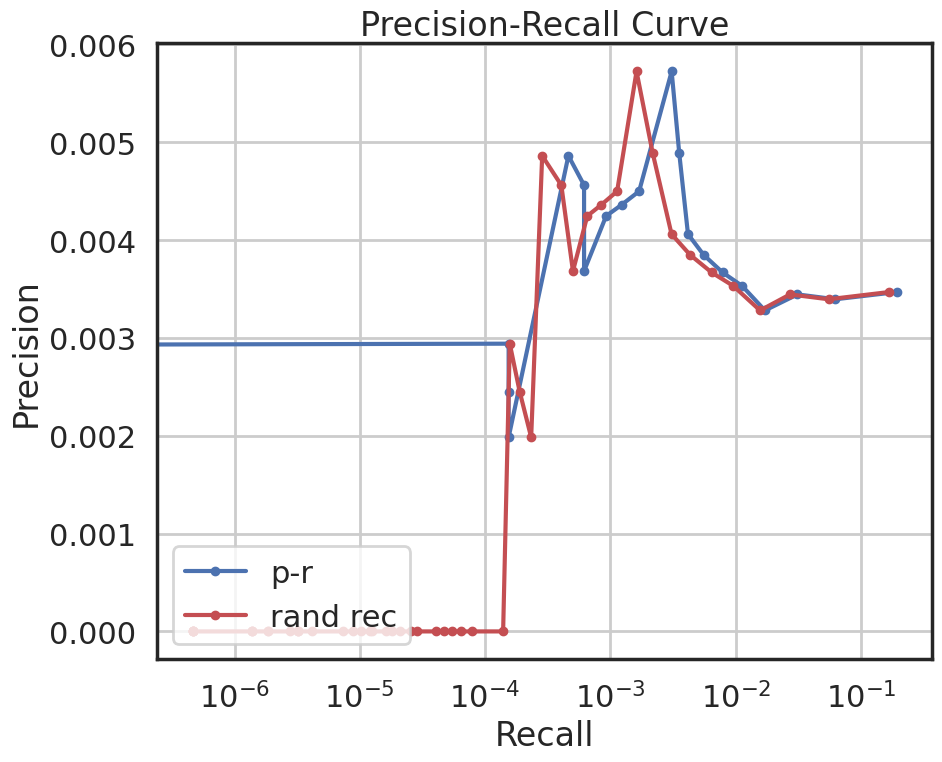

{'enriched_terms_Central': ['celltype.gmt__Hepatic stellate cells', 'celltype.gmt__Myofibroblasts'], 'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells'], 'significant_enriched_TFtargets': 3.7037037037037037, 'auprc': 0.0006707718899132214, 'pr_increase_to_random': (0.0009592811085173508, 0.026087378012196183), 'true_positive': 27, 'true_negative': 2150874, 'false_positive': 6470, 'false_negative': 6470, 'EPR': 1.387299317501535}
______________________________
kidney collecting duct principal cell
scprint



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 128 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
couldn't log to tensorboard
couldn't log to wandb


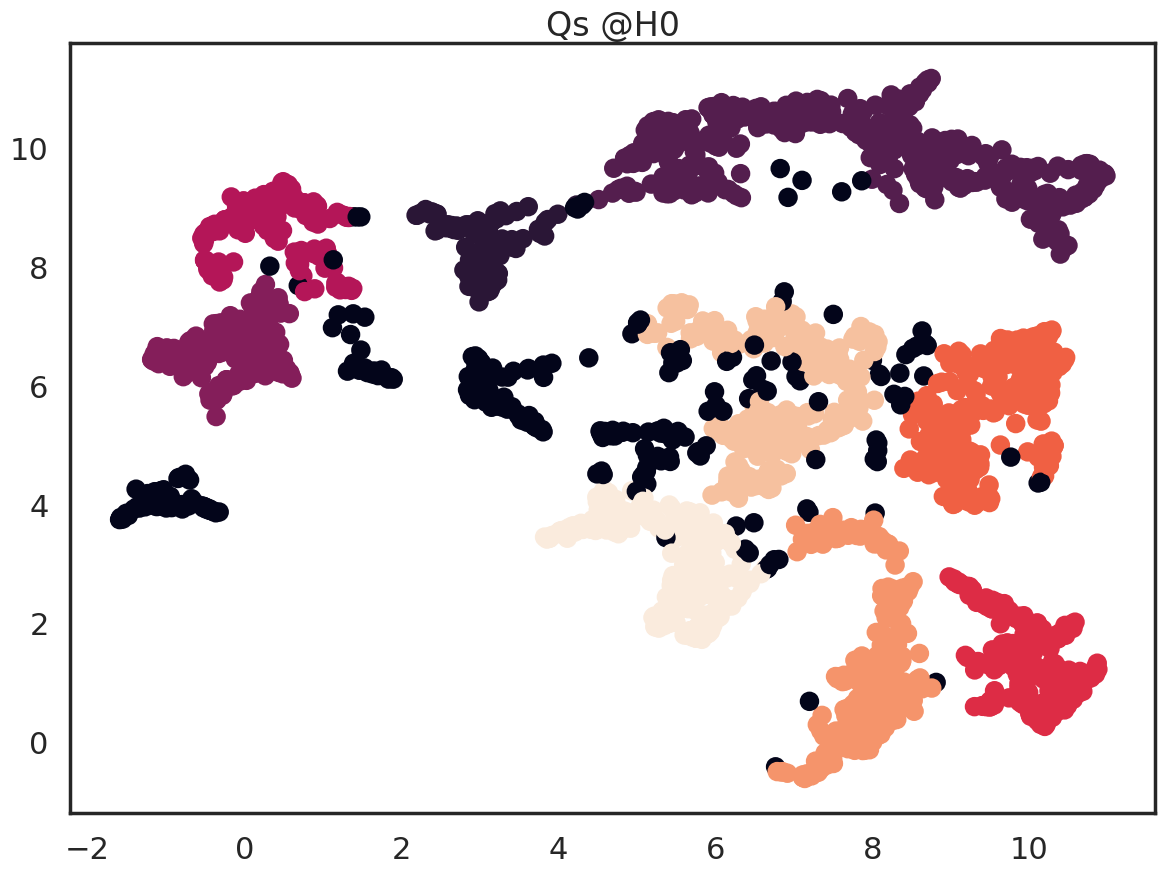

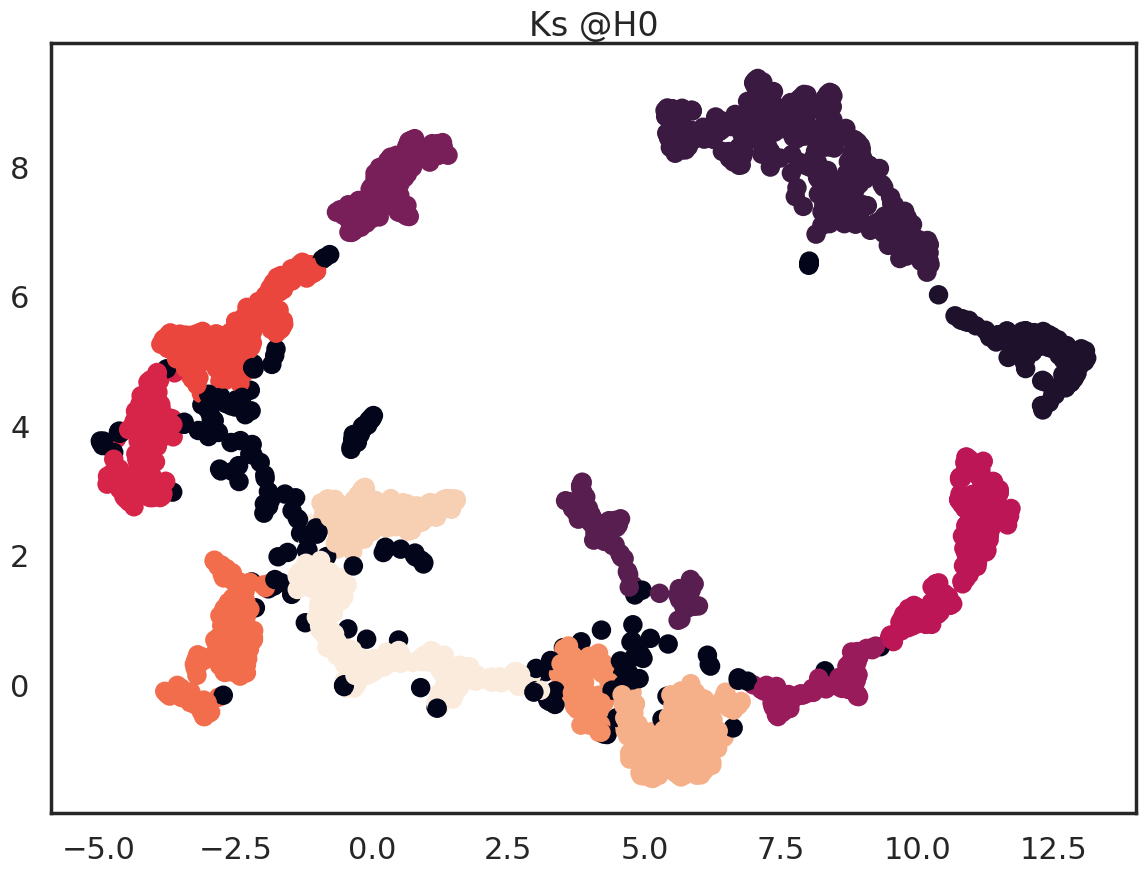

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:303: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 8223 ...
doing regression....


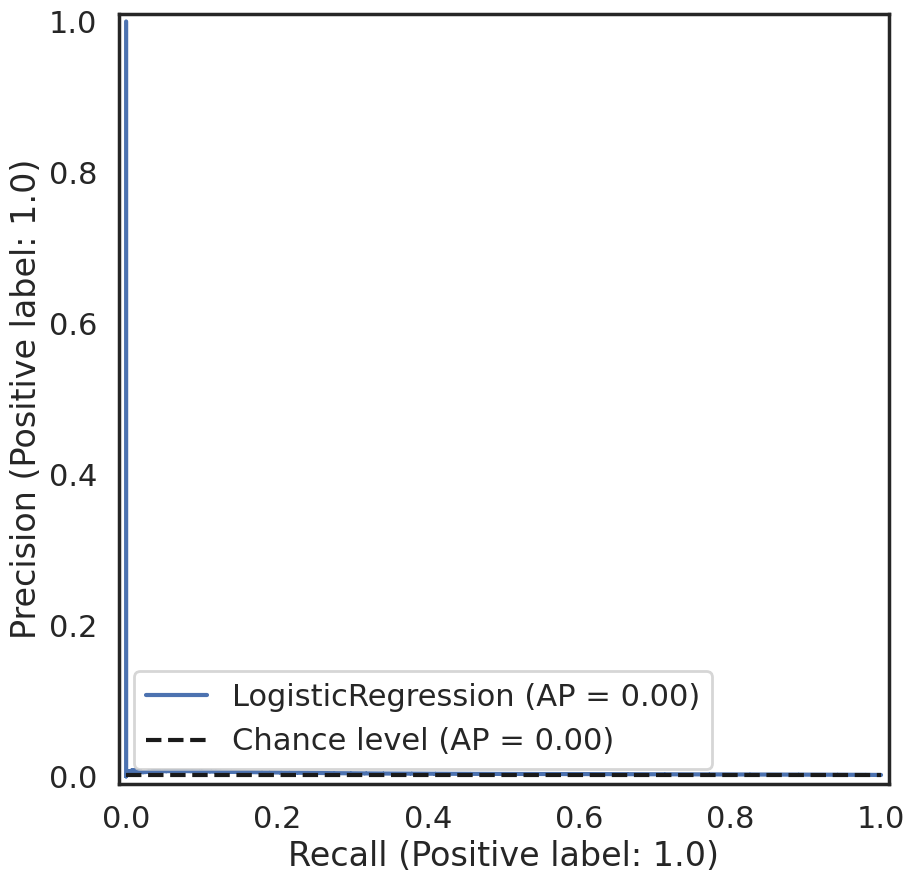

{'used_heads': 48, 'precision': 0.006351987734092651, 'random_precision': 0.0018481332324670702, 'recall': 0.01745673438675696, 'random_recall': 0.005079098433606265, 'predicted_true': 18262.0, 'number_of_true': 6645.0}
base enrichment


/home/ml4ig1/Documents code/GRnnData/grnndata/utils.py:309: DeprecationWarning: invalid escape sequence '\m'
  """


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [27]:
for celltype in list(set(adata.obs.cell_type))[1:]:
    print(celltype)
    print("scprint\n")
    grn = grn_inferer(layer=list(range(model.nlayers)), cell_type=celltype)
    grn, m = train_classifier(grn, C=0.4)
    grn.varp['GRN'] = grn.varp['classified']
    print(m)
    m = BenGRN(grn, do_auc=False).scprint_benchmark()
    print(m)
    print("genie3 TF only\n")
    subadata = adata[adata.obs.cell_type==celltype, adata.var.index.isin(grn_inferer.curr_genes)]
    grn = compute_genie3(subadata, nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
    m = BenGRN(grn).scprint_benchmark()
    print(m)
    print("genie3\n")
    grn = compute_genie3(subadata, nthreads=32)
    m = BenGRN(grn).scprint_benchmark()
    print(m)
    print("______________________________")

In [21]:
del model

## do the SRoys

In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

In [4]:
res = {}

In [7]:
preadata = get_sroy_gt(get="liu")
preadata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(preadata.copy())


/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


In [12]:
grn.var

uid   symbol ncbi_gene_ids         biotype  \
symbol                                                         
KLHL13   6wbOHptUcvvm   KLHL13         90293  protein_coding   
SLC7A2   3cStlWeH5o4H   SLC7A2          6542  protein_coding   
NDUFAB1  3QicjYwIvwpI  NDUFAB1          4706  protein_coding   
POLR2J   011FSJQXAkQG   POLR2J          5439  protein_coding   
WDR54    bzAJzpq0ez8Z    WDR54         84058  protein_coding   
...               ...      ...           ...             ...   
CFAP206  1EfKmpg1wuj9  CFAP206        154313  protein_coding   
GRIN2B   4foHnlnVvuY8   GRIN2B          2904  protein_coding   
SNURF    7IM2a87VBU2G    SNURF          8926  protein_coding   
PRSS50   5MgWa3ISvPPu   PRSS50         29122  protein_coding   
SCO2     011rccH0fHP2     SCO2          9997  protein_coding   

                                               description  \
symbol                                                       
KLHL13   kelch like family member 13 [Source:HGNC Symbo...   
SLC7A2   solute carrier family 7 member 2 [Source:HGNC ...   
NDUFAB1  NADH:ubiquinone oxidoreductase subunit AB1 [So...   
POLR2J   RNA polymerase II subunit J [Source:HGNC Symbo...   
WDR54    WD repeat domain 54 [Source:HGNC Symbol;Acc:HG...   
...                                                    ...   
CFAP206  cilia and flagella associated protein 206 [Sou...   
GRIN2B   glutamate ionotropic receptor NMDA type subuni...   
SNURF    SNRPN upstream open reading frame [Source:HGNC...   
PRSS50   serine protease 50 [Source:HGNC Symbol;Acc:HGN...   
SCO2     synthesis of cytochrome C oxidase 2 [Source:HG...   

                                   synonyms  organism_id  public_source_id  \
symbol                                                                       
KLHL13             FLJ10262|BKLHD2|KIAA1309            2               9.0   
SLC7A2                    HCAT2|CAT-2|ATRC2            2               9.0   
NDUFAB1                ACP1|SDAP|FASN2A|ACP            2               9.0   
POLR2J   RPB11|POLR2J1|RPB11A|RPB11M|HRPB14            2               9.0   
WDR54                              FLJ12953            2               9.0   
...                                     ...          ...               ...   
CFAP206        DJ382I10.1|FLJ25974|C6ORF165            2               9.0   
GRIN2B                       NMDAR2B|GLUN2B            2               9.0   
SNURF                                                  2               9.0   
PRSS50                           TSP50|CT20            2               9.0   
SCO2                             SCO1L|MYP6            2               9.0   

         created_by_id     mt  ...  log1p_mean_counts  pct_dropout_by_counts  \
symbol                         ...                                             
KLHL13               1  False  ...           0.156764              97.222222   
SLC7A2               1  False  ...           1.869148              25.000000   
NDUFAB1              1  False  ...           2.006990              15.277778   
POLR2J               1  False  ...           2.086938               8.333333   
WDR54                1  False  ...           0.711147              77.777778   
...                ...    ...  ...                ...                    ...   
CFAP206              1  False  ...           0.273922              94.444444   
GRIN2B               1  False  ...           0.239869              94.444444   
SNURF                1  False  ...           1.968404              16.666667   
PRSS50               1  False  ...           0.280060              94.444444   
SCO2                 1  False  ...           1.322879              47.222222   

        total_counts  log1p_total_counts  highly_variable  \
symbol                                                      
KLHL13     12.219774            2.581714             True   
SLC7A2    394.759336            5.980806             True   
NDUFAB1   463.743657            6.141486             True   
POLR2J    508.334

In [11]:
grn_inferer.model.attn.get().shape

torch.Size([12, 44764, 2, 8, 64])

In [5]:
curr = utils.fileToList("curr_genes.csv")
Tensor

[autoreload of scprint.tasks.denoise failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/Documents code/scPRINT/scprint/tasks/denoise.py", line 85
    se

In [8]:
sub = sub[:, sub.var.symbol.isin(curr)]
sub = sub[:, sub.var.index.isin(model.genes)]

In [19]:
import anndata as ad
adata = ad.AnnData(var=curr)
adata.varp['GRN'] = np.load("adj_all_v2.npy")

In [26]:
adata.var['symbol'] = adata.var[0].tolist()
adata.var.index = adata.var[0].tolist()

## the high results quality is due to a head that gets activated when it sees POU5F1 and also a bit with some related TFs

In [41]:
m

{'used_heads': 2,
 'precision': 0.14371617558628982,
 'random_precision': 0.04241810820758189,
 'recall': 0.17281272595806219,
 'random_recall': 0.051006011532327325,
 'predicted_true': 1663.0,
 'number_of_true': 1383.0}

pred shape (11, 2977, 96)
true elem 714 ...
doing regression....


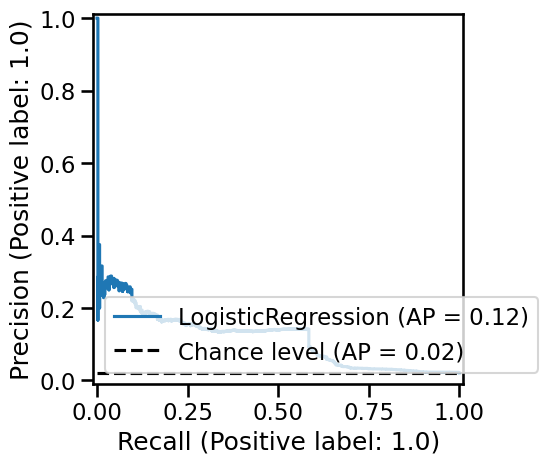

> /home/ml4ig1/Documents code/benGRN/bengrn/base.py(353)train_classifier()
    351     import /home/ml4ig1/Documents code/benGRN/bengrn/base.py(353)train_classifier()
    351     import pdb
    352     pdb.set_trace()
--> 353     grn.varp["classified"] = clf.predict(adj.reshape(-1, adj.shape[-1])).reshape(
    354         len(grn.var), len(grn.var)
    355     )



In [29]:
grn, m = train_classifier(adata, other=preadata, C=1, class_weight={1:10,0:1}, max_iter=4_000, train_size=0.4)

In [31]:
(grn.varp['classified'].sum(1)>0).sum()

51

In [33]:
grn.varp['classified'][grn.varp['classified'].sum(1)>0].sum(1)

array([2.974e+03, 2.972e+03, 2.595e+03, 2.971e+03, 1.000e+00, 3.050e+02,
       2.977e+03, 1.577e+03, 2.977e+03, 1.214e+03, 2.921e+03, 1.000e+00,
       1.000e+00, 2.615e+03, 2.489e+03, 2.973e+03, 2.972e+03, 2.429e+03,
       2.977e+03, 2.967e+03, 7.100e+01, 2.973e+03, 2.973e+03, 1.006e+03,
       1.737e+03, 2.792e+03, 2.370e+03, 2.971e+03, 2.507e+03, 1.500e+01,
       2.139e+03, 1.550e+02, 2.974e+03, 4.980e+02, 2.786e+03, 5.600e+01,
       2.977e+03, 1.300e+01, 2.879e+03, 4.000e+02, 2.018e+03, 2.252e+03,
       1.359e+03, 2.642e+03, 2.977e+03, 2.847e+03, 1.004e+03, 1.656e+03,
       2.977e+03, 1.325e+03, 5.860e+02])

In [35]:
grn.var[grn.varp['classified'].sum(1)>0].index

Index(['BZW1', 'AK6', 'SNU13', 'PHF5A', 'GRPEL1', 'DSE', 'SRSF3', 'PFDN1',
       'SKP1', 'UMPS', 'NCL', 'PSMD14', 'PLEKHB2', 'PRDX1', 'SET', 'HAT1',
       'SERINC3', 'CCNB1', 'PPIL1', 'RSL24D1', 'SRP14', 'RPL32', 'G3BP1',
       'RMND5B', 'RPL7L1', 'DPH3', 'EEF1A1', 'RPL9', 'HNRNPH1', 'CNBP',
       'PA2G4', 'CYCS', 'IMPDH2', 'NPM1', 'IST1', 'PPIA', 'RPS26', 'MT-CO2',
       'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'DAXX',
       'GPANK1', 'POU5F1', 'MT-ND4L', 'TOMM6', 'RPL41', 'TMA7'],
      dtype='object')

In [32]:
preadata.grn[preadata.grn.sum(1)>0].sum(1)

ATF3         96.0
CBX8         87.0
CDX2        244.0
CTBP2        72.0
EED           1.0
ESRRB       810.0
JARID2      223.0
JUN         324.0
KLF2          1.0
KLF4       1497.0
KLF5          5.0
MYC         516.0
MYCN         49.0
NANOG      1032.0
POU5F1     1858.0
PRDM14      180.0
REST         46.0
RXRA         88.0
SALL4       176.0
SAP30         6.0
SETDB1      132.0
SMAD1         3.0
SOX17        41.0
SOX2       1129.0
STAT3        32.0
SUZ12       389.0
TBX3         67.0
TCF3       1300.0
TFCP2L1      56.0
TRIM28        7.0
ZFP42        11.0
ZFX          18.0
ZNF281       41.0
dtype: float64

In [47]:
grn.varp['classified'][grn.varp['classified'].sum(1)>0].sum(1)

array([4.000e+01, 4.000e+01, 3.000e+00, 2.000e+00, 5.400e+01, 2.097e+03,
       9.000e+00])

# doing all SROY

In [5]:
preadata = get_sroy_gt(get="semrau", species="mouse")
adata = preprocessor(preadata.copy()) 

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


/tmp/ipykernel_430794/3447886684.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (13, 2949, 96)
true elem 234 ...
doing regression....


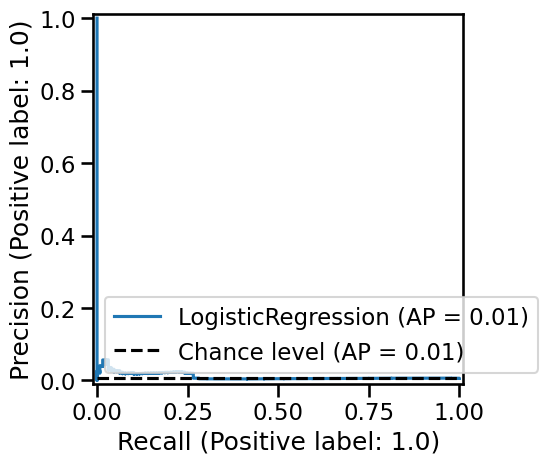

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 38.69 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(13, 2949) Ctcf        2.0
Jarid2     64.0
Mafk        2.0
Myc        64.0
Polr2a      2.0
Rest        5.0
Rnf2        0.0
Smad1       0.0
Suz12      89.0
Zc3h11a     0.0
Zfp384      1.0
Zfp42       5.0
Zic3        0.0
dtype: float64
precision:  0.007775821596244132 
recall:  0.452991452991453 
random recall: 0.35558337898114095 
random precision: 0.006103763987792472


100%|██████████| 49/49 [00:00<00:00, 665.93it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0027216727837082494
overal increase: (mean, max) (0.00020067645703454457, 0.09740807401031204)


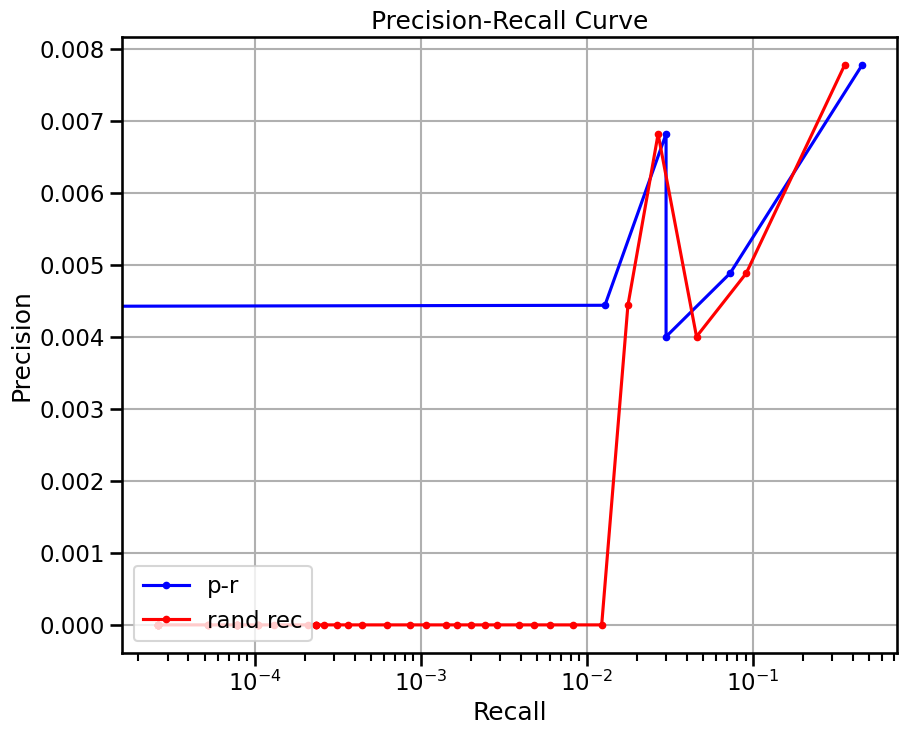

ValueError: the genes must contain at least one candidate regulator

In [21]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=3000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:100,0:1}, max_iter=4_000, train_size=0.4)
#grn.varp['GRN'] = grn.varp['classified']
res['semrau_scprint'] = m
#m = BenGRN(grn, do_auc=False, doplot=False).scprint_benchmark()
#res['semrau_scprint'].update(m)

subadata = adata[:, adata.var.index.isin(grn_inferer.curr_genes)]
subadata.var["isTF"]=False
subadata.var.loc[subadata.var.symbol.isin(grnutils.mTF), "isTF"]=True
grn = compute_genie3(subadata, nthreads=32)
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['semrau_genie3'] = m
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['semrau_genie3_tf'] = m
print(res)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 27.81 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(13, 2949) Ctcf        2.0
Jarid2     64.0
Mafk        2.0
Myc        64.0
Polr2a      2.0
Rest        5.0
Rnf2        0.0
Smad1       0.0
Suz12      89.0
Zc3h11a     0.0
Zfp384      1.0
Zfp42       5.0
Zic3        0.0
dtype: float64
precision:  0.006276971361318164 
recall:  0.6153846153846154 
random recall: 0.5984036309570389 
random precision: 0.006103763987792472


100%|██████████| 49/49 [00:00<00:00, 313.46it/s]


Area Under Precision-Recall Curve (AUPRC):  0.00402137330230725
overal increase: (mean, max) (0.0011661493248471904, 0.046369477702132844)


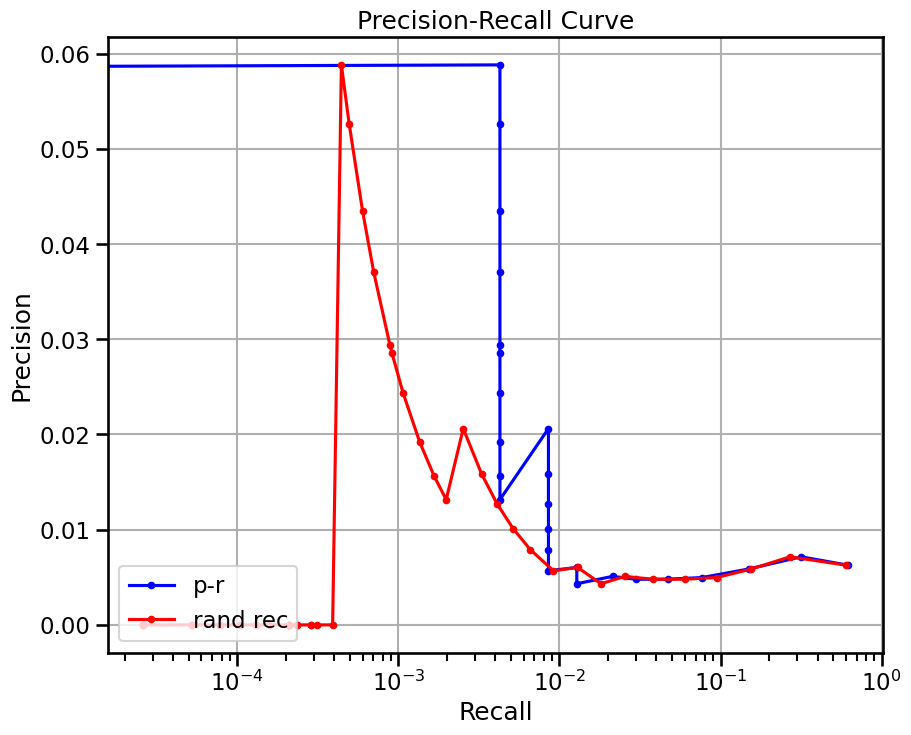

{'semrau_scprint': {'used_heads': 2, 'precision': 0.019584569732937686, 'random_precision': 0.005564491588053732, 'recall': 0.2578125, 'random_recall': 0.07325131504586359, 'predicted_true': 1685.0, 'number_of_true': 128.0}, 'semrau_genie3': {'auprc': 0.0027216727837082494, 'pr_increase_to_random': (0.00020067645703454457, 0.09740807401031204), 'true_positive': 0, 'true_negative': 37869, 'false_positive': 234, 'false_negative': 234, 'EPR': 0.0}, 'semrau_genie3_tf': {'auprc': 0.00402137330230725, 'pr_increase_to_random': (0.0011661493248471904, 0.046369477702132844), 'true_positive': 2, 'true_negative': 37871, 'false_positive': 232, 'false_negative': 232, 'EPR': 1.4072161117717004}}


In [23]:
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['semrau_genie3_tf'] = m
print(res)

In [5]:
preadata = get_sroy_gt(get="duren", species="mouse")
adata = preprocessor(preadata.copy())

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 464 renamining
filtered out 0 cells, 464 renamining
Removed 0 genes.
startin QC
Seeing 22 outliers (4.74% of total dataset):
done


In [9]:
res = {}

/tmp/ipykernel_457154/2520313425.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 14620


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (4, 3969, 96)
true elem 50 ...
doing regression....


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:341: RuntimeWarning: invalid value encountered in long_scalars
  "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),


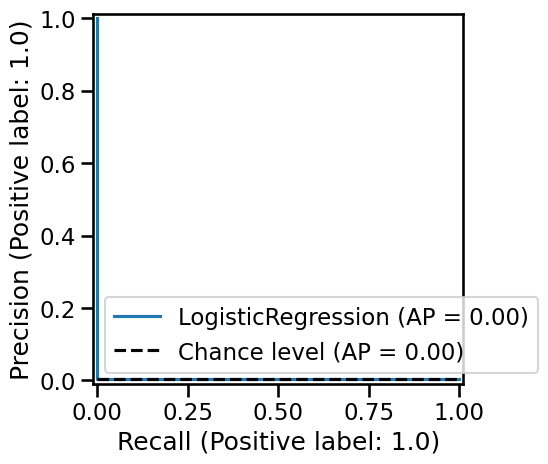

KeyboardInterrupt: 

In [10]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=4000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:300,0:1}, max_iter=4_000, train_size=0.4, return_full=False)
#grn.varp['GRN'] = grn.varp['classified']
res['duren_scprint'] = m
#m = BenGRN(grn, do_auc=False, doplot=False).scprint_benchmark()
#res['duren_scprint'].update(m)

subadata = adata[:, adata.var.index.isin(grn_inferer.curr_genes)]
subadata.var["isTF"]=False
subadata.var.loc[subadata.var.symbol.isin(grnutils.mTF), "isTF"]=True
grn = compute_genie3(subadata, nthreads=32)
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['duren_genie3'] = m
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['duren_genie3_tf'] = m
print(res)

In [11]:
preadata = get_sroy_gt(get="liu", species="human")
adata = preprocessor(preadata.copy())

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


/tmp/ipykernel_457154/2920458619.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (17, 3880, 96)
true elem 2357 ...
doing regression....


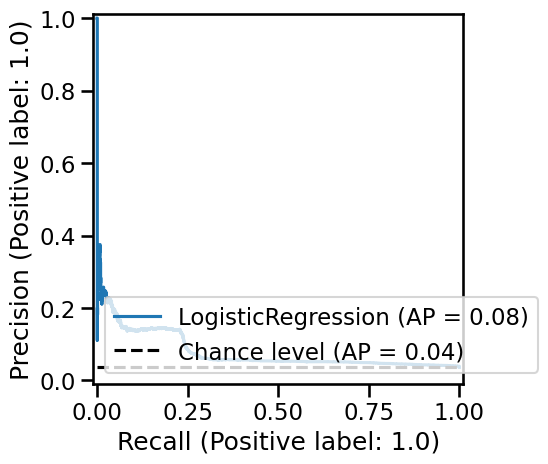

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 42.42 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(17, 3880) ATF3       34.0
CDX2       74.0
EED         0.0
ESRRB     238.0
JUN        83.0
KLF4      424.0
KLF5        4.0
MYC       130.0
NANOG     311.0
POU5F1    544.0
PRDM14     66.0
SALL4      44.0
SETDB1     38.0
SMAD1       0.0
SOX17      14.0
SOX2      352.0
TRIM28      1.0
dtype: float64
precision:  0.03979334279854867 
recall:  0.4280865507000424 
random recall: 0.3844147968465737 
random precision: 0.03573377804730139


100%|██████████| 49/49 [00:00<00:00, 383.17it/s]


Area Under Precision-Recall Curve (AUPRC):  0.021953717838662613
overal increase: (mean, max) (0.005940188098210997, 0.04367175385346872)


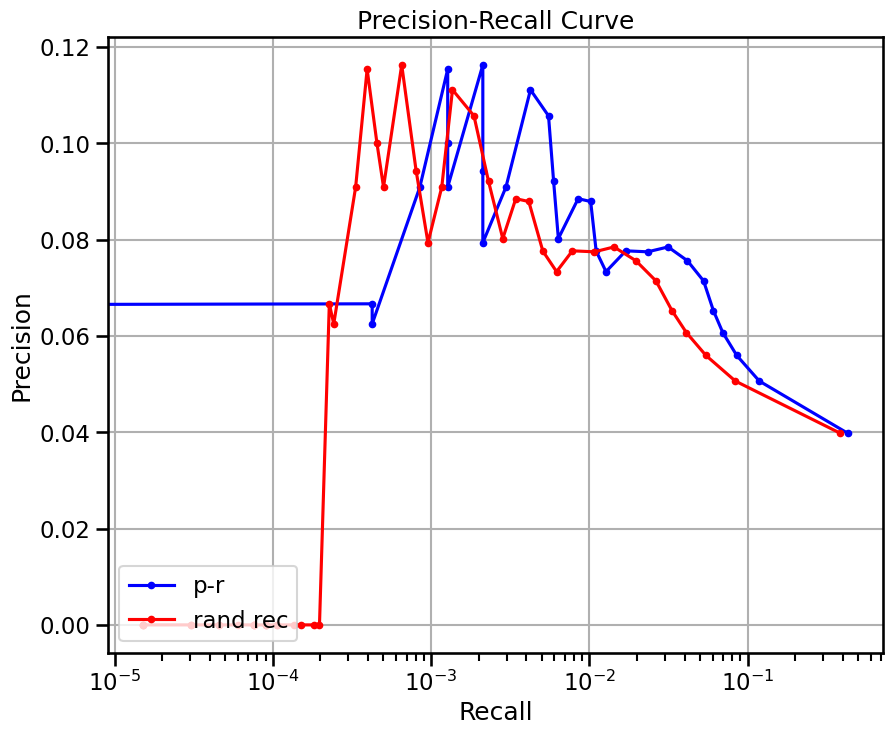

ValueError: the genes must contain at least one candidate regulator

In [12]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=4000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)
#grn.varp['GRN'] = grn.varp['classified']
res['liu_scprint'] = m
#m = BenGRN(grn, do_auc=False, doplot=False).scprint_benchmark()
#res['liu_scprint'].update(m)

subadata = adata[:, adata.var.index.isin(grn_inferer.curr_genes)]
subadata.var["isTF"]=False
subadata.var.loc[subadata.var.symbol.isin(grnutils.TF), "isTF"]=True
grn = compute_genie3(subadata, nthreads=32)
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['liu_genie3'] = m
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['liu_genie3_tf'] = m
print(res)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 31.47 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(17, 3880) ATF3       34.0
CDX2       74.0
EED         0.0
ESRRB     238.0
JUN        83.0
KLF4      424.0
KLF5        4.0
MYC       130.0
NANOG     311.0
POU5F1    544.0
PRDM14     66.0
SALL4      44.0
SETDB1     38.0
SMAD1       0.0
SOX17      14.0
SOX2      352.0
TRIM28      1.0
dtype: float64
precision:  0.04245472837022133 
recall:  0.8952057700466695 
random recall: 0.7534869617950273 
random precision: 0.03573377804730139


100%|██████████| 49/49 [00:00<00:00, 134.95it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04962386204668735
overal increase: (mean, max) (0.02058414261172673, 0.16892922852409487)


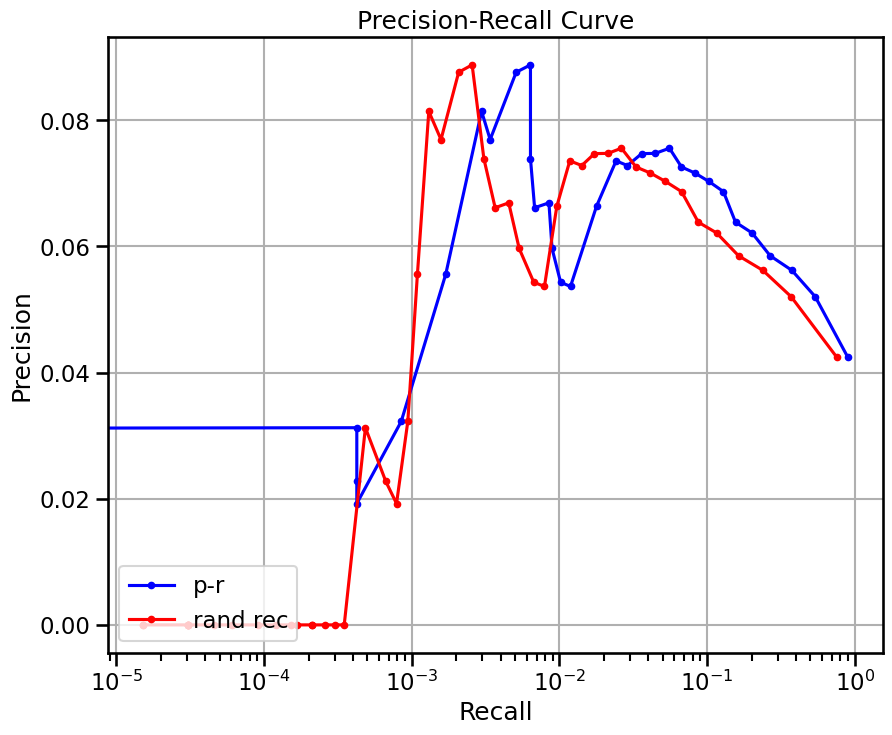

{'liu_scprint': {'used_heads': 3, 'precision': 0.0372193571912278, 'random_precision': 0.03610774206589852, 'recall': 1.0, 'random_recall': 0.9701334141904184, 'predicted_true': 38394.0, 'number_of_true': 1429.0}, 'liu_genie3': {'precision': 0.03979334279854867, 'recall': 0.4280865507000424, 'rand_recall': 0.3844147968465737, 'rand_precision': 0.03573377804730139, 'auprc': 0.021953717838662613, 'pr_increase_to_random': (0.005940188098210997, 0.04367175385346872), 'true_positive': 149, 'true_negative': 61395, 'false_positive': 2208, 'false_negative': 2208, 'EPR': 1.8763814636499685}, 'liu_genie3_tf': {'precision': 0.04245472837022133, 'recall': 0.8952057700466695, 'rand_recall': 0.7534869617950273, 'rand_precision': 0.03573377804730139, 'auprc': 0.04962386204668735, 'pr_increase_to_random': (0.02058414261172673, 0.16892922852409487), 'true_positive': 166, 'true_negative': 61412, 'false_positive': 2191, 'false_negative': 2191, 'EPR': 2.123618862359834}}



In [13]:
subadata.var.loc[subadata.var.symbol.isin(grnutils.TF), "isTF"]=True
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['liu_genie3_tf'] = m
print(res)

In [6]:
preadata = get_sroy_gt(get="chen", species="human")
adata = preprocessor(preadata.copy())

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [7]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=4000,
    max_cells=128,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)
#grn.varp['GRN'] = grn.varp['classified']
res['chen_scprint'] = m
#m = BenGRN(grn, do_auc=False, doplot=False).scprint_benchmark()
#res['chen_scprint'].update(m)

subadata = adata[:, adata.var.index.isin(grn_inferer.curr_genes)]
subadata.var["isTF"]=False
subadata.var.loc[subadata.var.symbol.isin(grnutils.TF), "isTF"]=True
grn = compute_genie3(subadata, nthreads=32)
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['chen_genie3'] = m
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.ar.isTF].index.tolist())
m = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)
res['chen_genie3_tf'] = m
print(res)

/tmp/ipykernel_519588/552743194.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


number of expressed genes in this cell type: 7906


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 128 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
couldn't log to tensorboard
couldn't log to wandb


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (7, 2481, 96)
true elem 98 ...


ValueError: Found input variables with inconsistent numbers of samples: [17367, 17276]

In [8]:
grn

GRnnData object with n_obs × n_vars = 128 × 2580
    obs: 'dataset', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'TFs'
    uns: 'unseen_genes', 'grn_scprint_params'
    varp: 'GRN'
    with a grn of 634417594 elements

In [9]:
preadata

GRnnData object with n_obs × n_vars = 385 × 8595
    obs: 'dataset', 'organism_ontology_term_id'
    varp: 'GRN'
    with a grn of 2969 elements

In [ ]:
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)

## just testing if we can make predictions per regulon